# Building Production Machine Learning Systems


This notebook creates a [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) to build an end-to-end Machine Learning system to solve the problem of classifying penguin species. With a SageMaker Pipeline, you can create, automate, and manage end-to-end Machine Learning workflows at scale.

You can find more information about Amazon SageMaker in the [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html). The [AWS Machine Learning Blog](https://aws.amazon.com/blogs/machine-learning/) is an excellent source to stay up-to-date with SageMaker.

This example uses the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data), the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) library, and the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/).

<img src='images/penguins.png' alt='Penguins' width="800">

This notebook is part of the [Machine Learning School](https://www.ml.school) program.


## Initial setup

:::{.callout-note}
Before running this notebook, follow the [Setup Instructions](https://program.ml.school/setup.html) for the program.
:::

Let's start by setting up the environment and preparing to run the notebook.


In [100]:
#| hide

%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import sys
import logging
import ipytest
import json
from pathlib import Path


CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(parents=True, exist_ok=True)
INFERENCE_CODE_FOLDER = CODE_FOLDER / "inference"
INFERENCE_CODE_FOLDER.mkdir(parents=True, exist_ok=True)

sys.path.extend([f"./{CODE_FOLDER}", f"./{INFERENCE_CODE_FOLDER}"])

DATA_FILEPATH = "home_data.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


We can run this notebook is [Local Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-local-mode.html) to test the pipeline in your local environment before using SageMaker. You can run the code in Local Mode by setting the `LOCAL_MODE` constant to `True`.


In [101]:
LOCAL_MODE = True

Let's load the S3 bucket name and the AWS Role from the environment variables:


In [102]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

S3_LOCATION = f"s3://{bucket}/houseprice"

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode or not:


In [103]:
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession, LocalPipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": None,
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

config["framework_version"] = "2.11"
config["py_version"] = "py39"

Let's now initialize a few variables that we'll need throughout the notebook:


In [104]:
import boto3

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

## Session 1 - Production Machine Learning is Different

In this session we'll run Exploratory Data Analysis on the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) and we'll build a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to split and transform the data. 

<a href="images/training.png" target="_blank"> <img src="images/training.png" alt="Training" style="max-width: 750px;" /></a>

We'll use a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for the transformations, and a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script. Check the [SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) for an introduction to the fundamental components of a SageMaker Pipeline.


### Step 1 - Exploratory Data Analysis

Let's run Exploratory Data Analysis on the dataset. The goal of this section is to understand the data and the problem we are trying to solve.

Let's load the Penguins dataset:


In [163]:
import pandas as pd
import numpy as np

houseraw = pd.read_csv(DATA_FILEPATH)

house = houseraw.drop(columns=['id','floors','yr_renovated','lat','long','condition','zipcode','yr_built','date','bedrooms','waterfront','sqft_lot','sqft_above','sqft_basement','sqft_lot15','view'])

houseraw["date"]= houseraw["date"].apply(lambda x: x[:4] if isinstance(x, str) else x)
#print(house["date"])
houseraw["date"] = pd.to_numeric(houseraw["date"])

#cols = list(house.columns)
#print(cols)
#cols[0], cols[1] = cols[1], cols[0]
#print(cols)
##house = house[cols]
        

house.head()

,price,bathrooms,sqft_living,grade,sqft_living15
0,221900.0,1.00,1180,7,1340
1,538000.0,2.25,2570,7,1690
2,180000.0,1.00,770,6,2720
3,604000.0,3.00,1960,7,1360
4,510000.0,2.00,1680,8,1800


In [106]:
for column in house.columns:
    proportion_of_nas = (sum(house[column].isnull())/len(house[column])) * 100 
    print(column, proportion_of_nas)

price 0.0
bathrooms 0.0
sqft_living 0.0
view 0.0
grade 0.0
sqft_living15 0.0


We can see the dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin



Now, let's get the summary statistics for the features in our dataset.


In [164]:
house.describe(include="all")

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,2014.322954,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,0.467616,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,2014.000000,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,2014.000000,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,2014.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,2015.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651360e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Let's now display the distribution of values for the three categorical columns in our data:


In [199]:
#col_distribution = house["view"].value_counts()

zip_avg_price = houseraw.groupby(by='zipcode')['price'].mean().reset_index(name='zip_avg_price')

#print(col_distribution)
print(zip_avg_price.sort_values('zip_avg_price', ascending=False))



    zipcode  zip_avg_price
24    98039   2.160607e+06
3     98004   1.355927e+06
25    98040   1.194230e+06
48    98112   1.095499e+06
41    98102   9.012583e+05
..      ...            ...
61    98148   2.849086e+05
0     98001   2.808047e+05
20    98032   2.512962e+05
64    98168   2.403284e+05
1     98002   2.342840e+05

[70 rows x 2 columns]


Next, let's check for any missing values in the dataset.


In [109]:
house.isnull().sum()

price            0
bathrooms        0
sqft_living      0
view             0
grade            0
sqft_living15    0
dtype: int64

In [166]:
print(houseraw.sort_values('price', ascending=False).head())


              id  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
7252  6762700020  2014  7700000.0         6       8.00        12050   27600.0   
3914  9808700762  2014  7062500.0         5       4.50        10040   37325.0   
9254  9208900037  2014  6885000.0         6       7.75         9890   31374.0   
4411  2470100110  2014  5570000.0         5       5.75         9200   35069.0   
1448  8907500070  2015  5350000.0         5       5.00         8000   23985.0   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
7252     2.5           0     3  ...     13        8570           3480   
3914     2.0           1     2  ...     11        7680           2360   
9254     2.0           0     4  ...     13        8860           1030   
4411     2.0           0     0  ...     13        6200           3000   
1448     2.0           0     4  ...     12        6720           1280   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \


Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.


In [110]:
"""from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)
penguins.isnull().sum()
"""

Let's visualize the distribution of categorical features.


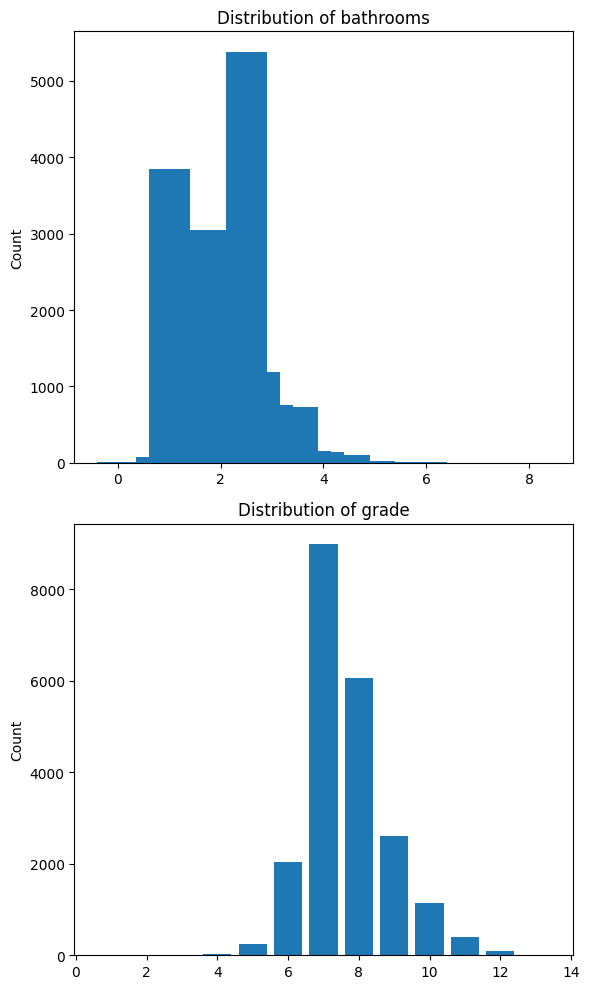

In [189]:
import matplotlib.pyplot as plt

# 'price', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
#'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'

bath_distribution = house["bathrooms"].value_counts()
grade_distribution = house["grade"].value_counts()
#date_distribution = house["date"].value_counts()

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

axs[0].bar(bath_distribution.index, bath_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of bathrooms")

axs[1].bar(grade_distribution.index, grade_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of grade")

# axs[2].bar(date_distribution.index, date_distribution.values)
# axs[2].set_ylabel("Count")
# axs[2].set_title("Distribution of date")

plt.tight_layout()
plt.show()


Let's visualize the distribution of numerical columns.


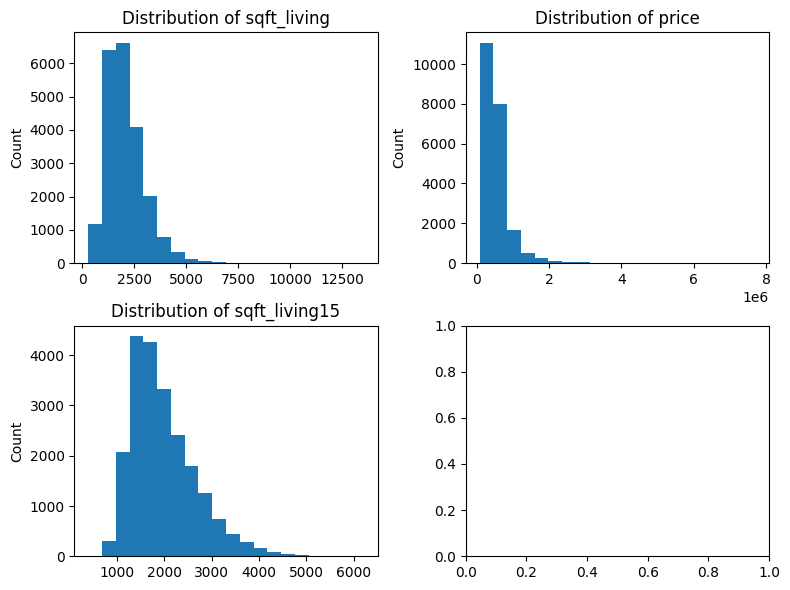

In [161]:
# 'price', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
#'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(house["sqft_living"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of sqft_living")

axs[0, 1].hist(house["price"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of price")

axs[1, 0].hist(house["sqft_living15"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of sqft_living15")

# axs[1, 1].hist(house["sqft_lot15"], bins=20)
# axs[1, 1].set_ylabel("Count")
# axs[1, 1].set_title("Distribution of sqft_lot15")

plt.tight_layout()
plt.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.


In [160]:
house.cov(numeric_only=True)

,price,bathrooms,sqft_living,grade,sqft_living15
price,1.347824e+11,148481.495749,2.367154e+08,288026.499738,1.472964e+08
bathrooms,1.484815e+05,0.593151,5.338120e+02,0.602005,3.001611e+02
sqft_living,2.367154e+08,533.811988,8.435337e+05,823.407664,4.761601e+05
grade,2.880265e+05,0.602005,8.234077e+02,1.381703,5.745907e+02
sqft_living15,1.472964e+08,300.161076,4.761601e+05,574.590703,4.697612e+05


Here are three examples of what we get from interpreting the covariance matrix below:

1. Penguins that weight more tend to have a larger culmen.
2. The more a penguin weights, the shallower its culmen tends to be.
3. There's a small variance between the culmen depth of penguins.

Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables.


In [190]:
houseraw.corr(numeric_only=True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.010128,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,...,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
date,0.010128,1.000000,0.003576,-0.009838,-0.026596,-0.029038,0.005468,-0.022315,-0.004165,0.001364,...,-0.030387,-0.023823,-0.015687,0.003507,-0.023707,0.001189,-0.029212,0.000270,-0.021734,-0.000085
price,-0.016762,0.003576,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,...,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,-0.009838,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,...,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,-0.026596,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,...,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,-0.029038,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,...,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.005468,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,...,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,-0.022315,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,...,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,-0.004165,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,...,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.001364,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,...,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have larger flippers.
2. Penguins with a shallower culmen tend to have larger flippers.
3. The length and depth of the culmen have a slight negative correlation.

Let's display the distribution of species by island.


In [115]:
# unique_species = penguins["species"].unique()

# fig, ax = plt.subplots(figsize=(6, 6))
# for species in unique_species:
#     data = penguins[penguins["species"] == species]
#     ax.hist(data["island"], bins=5, alpha=0.5, label=species)

# ax.set_xlabel("Island")
# ax.set_ylabel("Count")
# ax.set_title("Distribution of Species by Island")
# ax.legend()
# plt.show()

Let's display the distribution of species by sex.


In [116]:
# fig, ax = plt.subplots(figsize=(6, 6))

# for species in unique_species:
#     data = penguins[penguins["species"] == species]
#     ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

# ax.set_xlabel("Sex")
# ax.set_ylabel("Count")
# ax.set_title("Distribution of Species by Sex")

# ax.legend()
# plt.show()

### Step 2 - Creating the Preprocessing Script

Here's a high-level overview of the preprocessing step and the Processing Job that SageMaker creates behind the scenes:

<a href="images/preprocess-data.png" target="_blank"> <img src="images/preprocess-data.png" alt="High-level overview of the Preprocessing Data Step and SageMaker’s Processing Jobs" style="max-width: 750px;" /></a>

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run a script that will split and transform the data. This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.


The first step is to create the script that will split and transform the input data.


In [117]:
#print(np.array(house.price).reshape(-1, 1))

In [133]:
%%writefile {CODE_FOLDER}/preprocessor.py
#| label: preprocessing-script
#| echo: true
#| output: false
#| filename: preprocessor.py
#| code-line-numbers: true

import os
import tarfile
import tempfile
import joblib
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

def preprocess(base_directory):
    """
    This function loads the supplied data, splits it and transforms it.
    """

    df = _read_data_from_input_csv_files(base_directory)

    df = df.drop(columns=['id','floors','yr_renovated','lat','long','condition','zipcode','yr_built','date','bedrooms','waterfront','sqft_lot','sqft_above','sqft_basement','sqft_lot15','view'])

    #df["date"]= df["date"].apply(lambda x: x[:4] if isinstance(x, str) else x)
    #df["date"] = pd.to_numeric(df["date"])

    #cols = list(df.columns)
    #print(cols)
    #cols[0], cols[1] = cols[1], cols[0]
    #df = df[cols]
    
    target_transformer = ColumnTransformer(
         transformers=[("price", StandardScaler(), [0])]
     )
    
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        #StandardScaler()
    )

    numeric_transformer_scaler = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler()
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(drop='first')
    )
    
    features_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, make_column_selector(
                pattern='^(bathrooms|grade)$')),
            ("numeric_scaler", numeric_transformer_scaler, make_column_selector(
                pattern='^(sqft_living|sqft_living15)$'))
                #,
            #("categorical", categorical_transformer, ["view"]),
        ]
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_baselines(base_directory, df_train, df_test)

    # y_train = np.array(df_train.price).reshape(-1, 1)
    # y_validation = np.array(df_validation.price).reshape(-1, 1)
    # y_test = np.array(df_test.price).reshape(-1, 1)

    y_train = target_transformer.fit_transform(np.array(df_train.price.values).reshape(-1, 1))
    y_validation = target_transformer.transform(np.array(df_validation.price.values).reshape(-1, 1))
    y_test = target_transformer.transform(np.array(df_test.price.values).reshape(-1, 1))
    
    df_train = df_train.drop("price", axis=1)
    df_validation = df_validation.drop("price", axis=1)
    df_test = df_test.drop("price", axis=1)

    X_train = features_transformer.fit_transform(df_train)
    X_validation = features_transformer.transform(df_validation)
    X_test = features_transformer.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_model(base_directory, features_transformer)
    

def _read_data_from_input_csv_files(base_directory):
    """
    This function reads every CSV file available and concatenates
    them into a single dataframe.
    """

    input_directory = Path(base_directory) / "input"
    files = [file for file in input_directory.glob("*.csv")]
    
    if len(files) == 0:
        raise ValueError(f"The are no CSV files in {str(input_directory)}/")
        
    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)
    
    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """
    Splits the data into three sets: train, validation and test.
    """
    #Random
    #df_train, temp = train_test_split(df, test_size=0.3)
    #df_validation, df_test = train_test_split(temp, test_size=0.5)

    #Stratified
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_baselines(base_directory, df_train, df_test):
    """
    During the data and quality monitoring steps, we will need baselines
    to compute constraints and statistics. This function saves the 
    untransformed data to disk so we can use them as baselines later.
    """

    for split, data in [("train", df_train), ("test", df_test)]:
        baseline_path = Path(base_directory) / f"{split}-baseline"
        baseline_path.mkdir(parents=True, exist_ok=True)

        df = data.copy().dropna()

        # We want to save the header only for the train baseline
        # but not for the test baseline. We'll use the test baseline
        # to generate predictions later, and we can't have a header line
        # because the model won't be able to make a prediction for it.
        # header = split == "train"
        # df.to_csv(baseline_path / f"{split}-baseline.csv", header=header, index=False)
        #Changed to always have the header
        df.to_csv(baseline_path / f"{split}-baseline.csv", header=True, index=False)


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    This function concatenates the transformed features and the target variable, and
    saves each one of the split sets to disk.
    """

    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=True, index=False) #header=False,
    pd.DataFrame(validation).to_csv(validation_path / "validation.csv", header=True, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=True, index=False)


def _save_model(base_directory, features_transformer):
    """
    This function creates a model.tar.gz file that contains the two transformation
    pipelines we built to transform the data.
    """

    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, os.path.join(directory, "target.joblib"))
        joblib.dump(features_transformer, os.path.join(directory, "features.joblib"))
    
        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        #print(f"test {str(model_path)}\model.tar.gz")
        #print(f"Path for tar: {str(model_path / 'model.tar.gz')}")
    
        with tarfile.open(f"{str(model_path / 'model.tar.gz')}", "w:gz") as tar:
            tar.add(os.path.join(directory, "target.joblib"), arcname="target.joblib")
            tar.add(os.path.join(directory, "features.joblib"), arcname="features.joblib")

    
if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/preprocessor.py


In [119]:
#import sagemaker

#print(sagemaker.__version__)


Let's test the script to ensure everything is working as expected:


In [134]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib
from preprocessor import preprocess


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    preprocess(base_directory=directory)
    
    yield directory
    
    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)
    
    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    print(f'model_path: {model_path}')

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=0)
    print('train')
    print(train.head())
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=0)
    test = pd.read_csv(directory / "test" / "test.csv", header=0)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 4

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


# def test_train_baseline_is_not_transformed(directory):
#     baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv", header=None)

#     island = baseline.iloc[:, 1].unique()

#     assert "Biscoe" in island
#     assert "Torgersen" in island
#     assert "Dream" in island


# def test_test_baseline_is_not_transformed(directory):
#     baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv", header=None)

#     island = baseline.iloc[:, 1].unique()

#     assert "Biscoe" in island
#     assert "Torgersen" in island
#     assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "price"


def test_test_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] == "price"

..model_path: C:\Users\sebas\AppData\Local\Temp\tmpfp79vudh\model
.train
      0    1         2         3         4
0  1.00  7.0 -0.929013 -0.923764 -0.111355
1  2.50  8.0 -0.918206 -1.083639 -0.138446
2  1.50  8.0  0.432694 -0.255193  0.102664
3  2.25  7.0  0.205743 -0.313330 -0.168246
4  2.50  8.0  0.109559  0.504943 -0.544810
...
======================================== warnings summary =========================================
t_e02728d4f87e43e7a7db5c5d4e68d06d.py::test_preprocess_generates_data_splits
t_e02728d4f87e43e7a7db5c5d4e68d06d.py::test_preprocess_generates_baselines
t_e02728d4f87e43e7a7db5c5d4e68d06d.py::test_preprocess_creates_two_models
t_e02728d4f87e43e7a7db5c5d4e68d06d.py::test_splits_are_transformed
t_e02728d4f87e43e7a7db5c5d4e68d06d.py::test_train_baseline_includes_header
t_e02728d4f87e43e7a7db5c5d4e68d06d.py::test_test_baseline_includes_header
  c:\Users\sebas\Documents\GitHub\ml.school\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:1167: UserWarnin

### Step 3 - Setting up the Processing Step

Let's now define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that we'll use in the pipeline to run the script that will split and transform the data.


Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step. You can find more information about this topic in [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html). Let's define a caching policy that we'll reuse on every step:


In [121]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a parameter to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. To read more about these parameters, check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html).


In [167]:
from sagemaker.workflow.parameters import ParameterString

dataset_location = ParameterString(
    name="dataset_location",
    #default_value=f"{S3_LOCATION}/sampledata",
    default_value=f"{S3_LOCATION}/data",
)

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch the Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK. 

SageMaker manages the infrastructure of a Processing Job. It provisions resources for the duration of the job, and cleans up when it completes. The Processing Container image that SageMaker uses to run a Processing Job can either be a SageMaker built-in image or a custom image.

The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.

In [168]:
#| code: true
#| output: false
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    #Originally 1 instance
    instance_count=1,
    #bumbed it up to 2
    #instance_count=2,
    role=role,
    sagemaker_session=config["session"],
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Let's now define the Processing Step that we'll use in the pipeline. This step requires a list of inputs that we need on the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [169]:
# | code: true
# | output: false

from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput


preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{CODE_FOLDER}/preprocessor.py",
        inputs=[
            ProcessingInput(
                #Original
                source=dataset_location, destination="/opt/ml/processing/input"

                #Multiple instances
                #source=dataset_location, destination="/opt/ml/processing/input", s3_data_distribution_type="ShardedByS3Key"
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

c:\Users\sebas\Documents\GitHub\ml.school\.venv\lib\site-packages\sagemaker\workflow\pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 4 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [170]:
# | code: true
# | output: false

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

session1_pipeline = Pipeline(
    name="session1-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session1_pipeline.upsert(role_arn=role)

{'PipelineArn': 'session1-pipeline'}

We can now start the pipeline:


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [126]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session1_pipeline.start()

#Override location
#session1_pipeline.start(
#    parameters=dict(
#        dataset_location=f"{S3_LOCATION}/sampledata"
#    )
#)

Couldn't find program: 'false'


## Session 2 - Building Models And The Training Pipeline

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) we built in the previous session with a step to train a model. We'll explore the [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) and the [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning).

<a href="images/training.png" target="_blank"> <img src="images/training.png" alt="Training" style="max-width: 750px;" /></a>

We'll introduce [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and use them during training. For more information about this topic, check the [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).


### Step 1 - Creating the Training Script

Here's a high-level overview of the training step and the Training Job that SageMaker creates behind the scenes:

<a href="images/train-model.png" target="_blank"> <img src="images/train-model.png" alt="High-level overview of the Train Model Step and SageMaker's Training Jobs" style="max-width: 750px;" /></a>

This following script is responsible for training a neural network using the train data, validating the model, and saving it so we can later use it:


In [172]:
import os
import argparse

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import accuracy_score

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
# key
import statsmodels.formula.api as smf

import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# key
from statsmodels.formula.api import ols

from sklearn import datasets, linear_model
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import r2_score
#key
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
#key
from sklearn.linear_model import LinearRegression
#key
from sklearn.model_selection import train_test_split

house2 = house

X = house2.drop('price', axis=1)
y = np.log(house2['price'])

house2['sqft_living15'] = np.log(house2['sqft_living15'])
house2['sqft_living'] = np.log(house2['sqft_living'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

      price  bathrooms  sqft_living  grade  sqft_living15
0  221900.0       1.00     7.073270      7       7.200425
1  538000.0       2.25     7.851661      7       7.432484
2  180000.0       1.00     6.646391      6       7.908387
3  604000.0       3.00     7.580700      7       7.215240
4  510000.0       2.00     7.426549      8       7.495542


C:\Users\sebas\AppData\Local\Temp\ipykernel_1368\789299117.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


<Figure size 640x480 with 0 Axes>

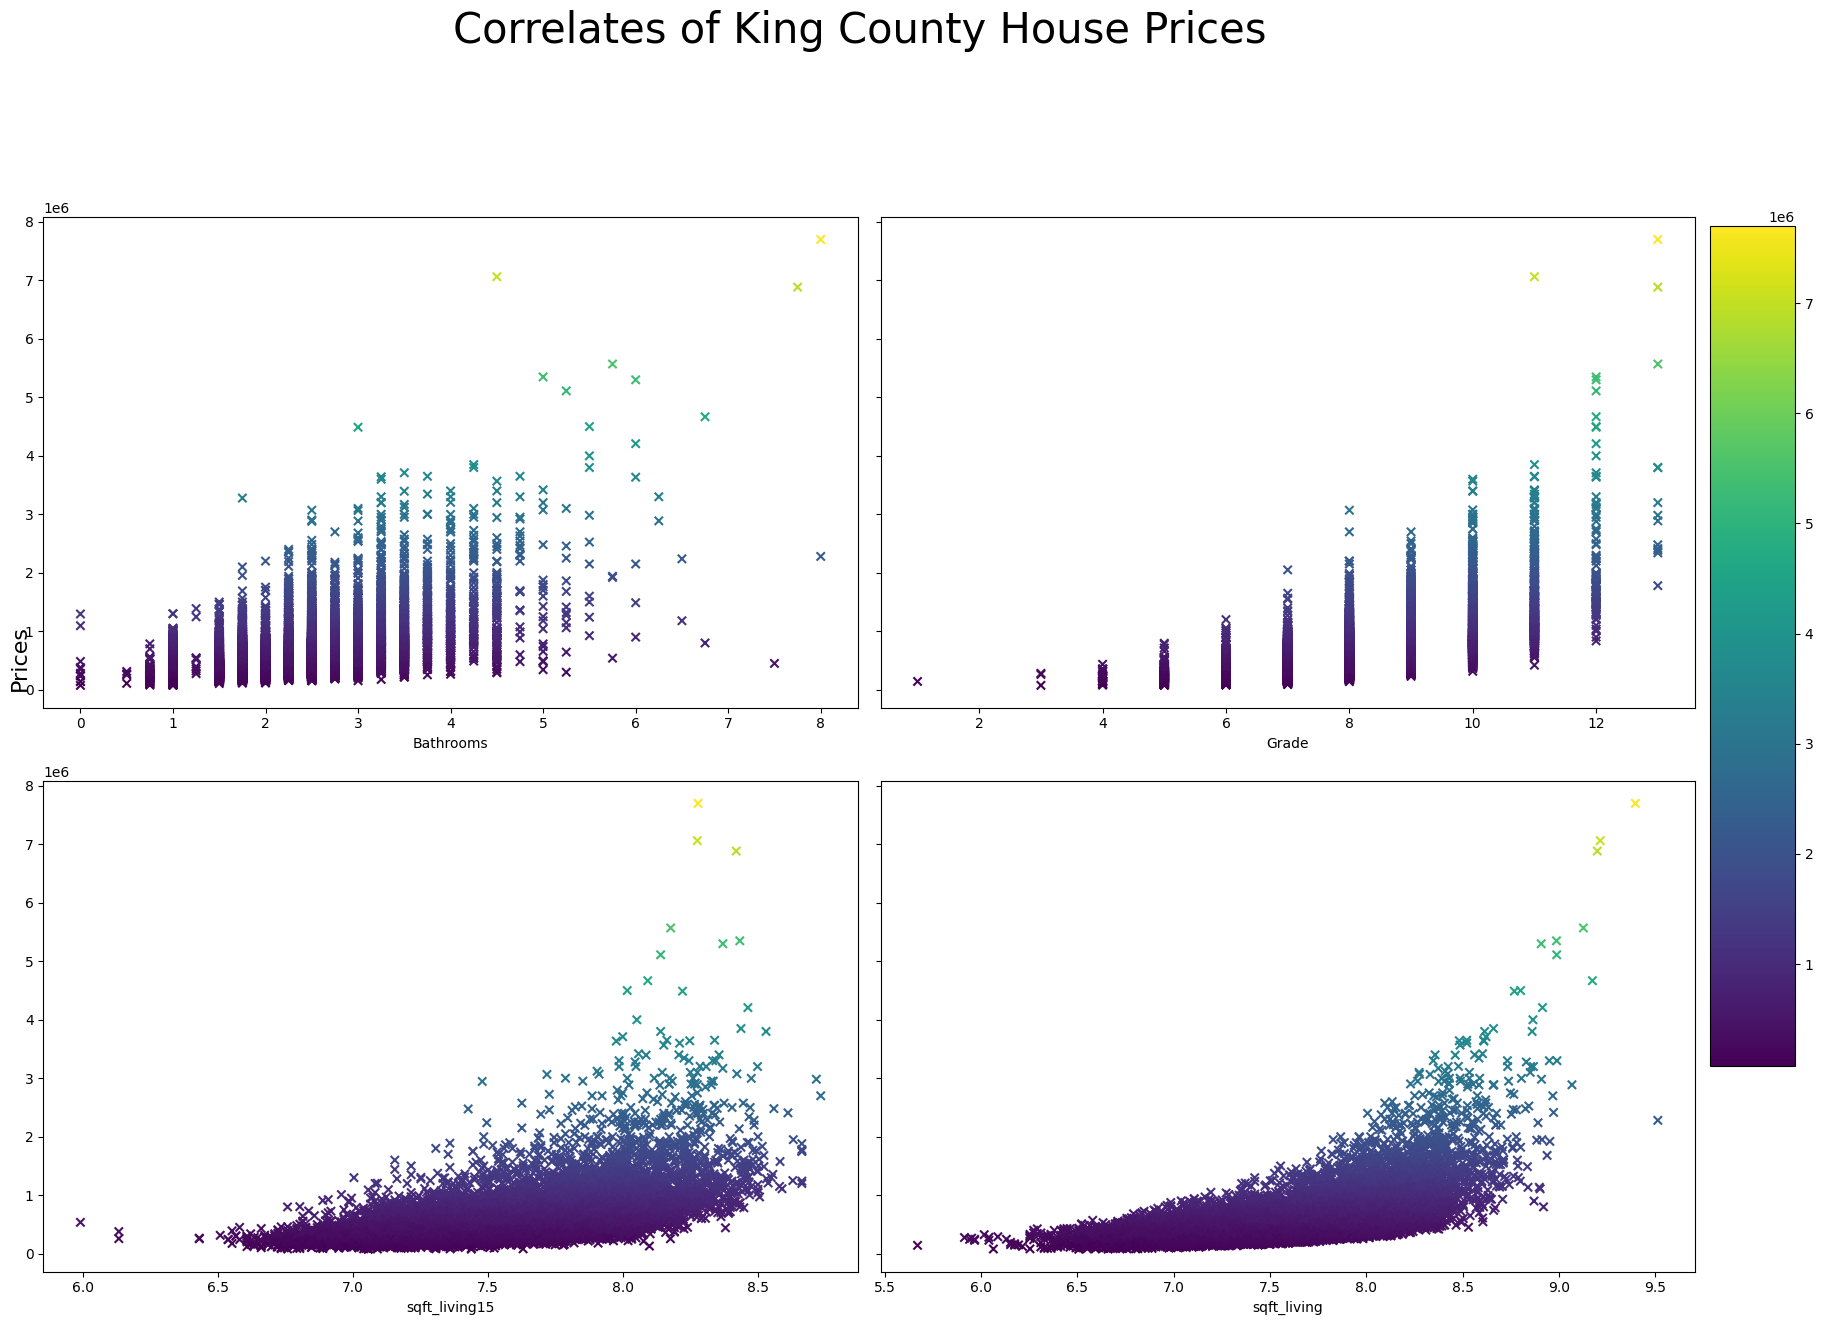

In [173]:
print(house.head())

price = house['price']
bath = house['bathrooms']
grade = house['grade']
sqft_living15 = house['sqft_living15']
sqft_living = house['sqft_living']

f = plt.figure()
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex=False, sharey = True, figsize=(17,12))

f.suptitle('Correlates of King County House Prices', fontsize=30, y=1.1, fontname='Silom')
f.text(0.0001, 0.56, 'Prices', va='center', rotation='vertical', fontsize=16, fontname='Silom')

sc = axes[0][0].scatter(bath, price, c = price, marker = "x")
axes[0][0].set_xlabel('Bathrooms')

axes[0][1].scatter(grade, price, c = price, marker = "x")
axes[0][1].set_xlabel('Grade')

axes[1][0].scatter(sqft_living15, price, c = price, marker = "x")
axes[1][0].set_xlabel('sqft_living15')

axes[1][1].scatter(sqft_living, price, c = price, marker = "x")
axes[1][1].set_xlabel('sqft_living')

cbar_ax = f.add_axes([1, 0.22, 0.05, 0.7])

f.colorbar(sc, cax=cbar_ax)

f.tight_layout()
plt.show()


C:\Users\sebas\AppData\Local\Temp\ipykernel_1368\3961019081.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     4930.
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:15:53   Log-Likelihood:            -3.0060e+05
No. Observations:               21613   AIC:                         6.012e+05
Df Residuals:                   21608   BIC:                         6.012e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.428e+06   5.55e+04    -43.773

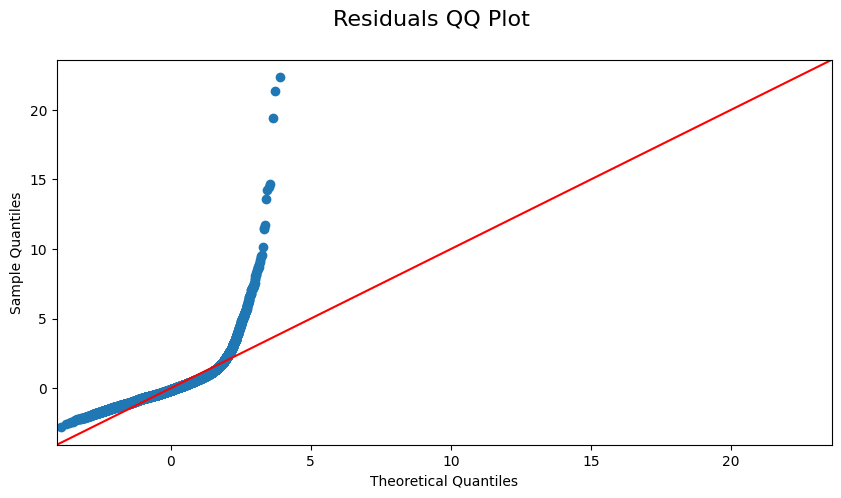

In [174]:


linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
#print('Train Mean Squared Error:', train_mse)
#print('Test Mean Squared Error:', test_mse)




Model_1 = smf.ols(formula="price ~ grade + bathrooms + sqft_living15  + sqft_living", data=house2).fit()
print(Model_1.summary())

residuals = Model_1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.suptitle('Residuals QQ Plot', fontsize=16, fontname='silom')
fig.set_size_inches(10, 5)
fig.show()

In [128]:
import statsmodels

print(statsmodels.__version__)

0.14.1


In [213]:
%%writefile {CODE_FOLDER}/train.py
#| label: training-script
#| echo: true
#| output: false
#| filename: train.py
#| code-line-numbers: true

import os
import argparse

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import accuracy_score

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import SGD

# models used for linear regression
#import matplotlib.pyplot as plt
#%matplotlib inline
#import scipy.stats as stats
# key

#import statsmodels
#import statsmodels.formula.api as smf

#import statsmodels.stats.api as sms
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor
# key
#from statsmodels.formula.api import ols

from sklearn import datasets, linear_model
#import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
#key
from sklearn.linear_model import LinearRegression
#key
from sklearn.model_selection import train_test_split

import joblib



def train(model_directory, train_path, validation_path):
    X_train = pd.read_csv(Path(train_path) / "train.csv")
    print(X_train)
    y_train = X_train[X_train.columns[-1]]
    X_train.drop(X_train.columns[-1], axis=1, inplace=True)
    
    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation.drop(X_validation.columns[-1], axis=1, inplace=True)


    model = LinearRegression()
    model.fit(X_train, y_train)

   

    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_validation)

    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_validation

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_validation, y_hat_test)
    print('Train Mean Squared Error:', train_mse)
    print('Test Mean Squared Error:', test_mse)

    print('Model coefficients:', model.coef_)
    print('Model intercept:', model.intercept_)
    print('Model train R^2:',model.score(X_train, y_train))
    print('Model test R^2:',model.score(X_validation, y_validation))
    
    
        
    # model = Sequential([
    #     Dense(10, input_shape=(X_train.shape[1],), activation="relu"),
    #     Dense(8, activation="relu"),
    #     Dense(3, activation="softmax"),
    # ])
    
    # model.compile(
    #     optimizer=SGD(learning_rate=0.01),
    #     loss="sparse_categorical_crossentropy",
    #     metrics=["accuracy"]
    # )

    # model.fit(
    #     X_train, 
    #     y_train, 
    #     validation_data=(X_validation, y_validation),
    #     epochs=epochs, 
    #     batch_size=batch_size,
    #     verbose=2,
    # )

    # predictions = np.argmax(model.predict(X_validation), axis=-1)
    # print(f"Validation accuracy: {accuracy_score(y_validation, predictions)}")
    
    model_filepath = Path(model_directory) / "001"

    model_filepath.mkdir(parents=True, exist_ok=True)

    #model_filepath = os.path.join(model_filepath_folder, 'linear_regression_model.joblib')

    joblib.dump(model, os.path.join(model_filepath, 'linear_regression_model.joblib')) 

    print(f"model_filepath: {model_filepath}") 

    #Add conditional to zip the model and send to S3 if in local mode
    

if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to 
    # the entry point as script arguments. 

    train(
        # This is the location where we need to save our model. SageMaker will
        # create a model.tar.gz file with anything inside this directory when
        # the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],

        # SageMaker creates one channel for each one of the inputs to the
        # Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],

    )

Overwriting code/train.py


Let's test the script to ensure everything is working as expected:


In [214]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib

from preprocessor import preprocess
from train import train


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    print(f'directory: {directory}')
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation"
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_saves_a_folder_with_model_assets(directory):
    output = os.listdir(directory / "model")
    assert "001" in output
    
    assets = os.listdir(directory / "model" / "001")
    assert "linear_regression_model.joblib" in assets

directory: C:\Users\sebas\AppData\Local\Temp\tmpawpvaqv2
          0    1         2         3         4
0      2.00  7.0 -0.844880 -0.462421 -0.163515
1      2.50  8.0  1.340992  0.572285  0.040074
2      2.25  7.0 -0.507755 -0.331261 -0.684703
3      1.00  6.0 -0.899255 -1.380540 -0.923581
4      2.25  9.0  0.199119  1.504978  0.645411
...     ...  ...       ...       ...       ...
15124  2.50  7.0 -0.312006 -0.331261 -0.801563
15125  2.00  8.0 -0.562130 -0.192814 -0.057649
15126  1.50  5.0 -1.269005 -0.593580 -0.774282
15127  1.00  7.0 -1.051505 -0.826754  0.132367
15128  1.75  7.0 -0.507755  0.033072  0.501542

[15129 rows x 5 columns]
Train Mean Squared Error: 0.4687270219968218
Test Mean Squared Error: 0.4392467565834351
Model coefficients: [-0.09542493  0.27349029  0.49597904  0.01768087]
Model intercept: -1.8918858135789258
Model train R^2: 0.5312729780031782
Model test R^2: 0.5459440407699305
model_filepath: C:\Users\sebas\AppData\Local\Temp\tmpawpvaqv2\model\001
.
============

### Step 2 - Setting up the Training Step

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information.

SageMaker uses the concept of an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to handle end-to-end training and deployment tasks. For this example, we will use the built-in [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator) to run the training script we wrote before. 


SageMaker manages the infrastructure of a Training Job. It provisions resources for the duration of the job, and cleans up when it completes. The Training Container image that SageMaker uses to run a Training Job can either be a SageMaker built-in image or a custom image.

The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region. Here, you can also check the available SageMaker [Deep Learning Container images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

We are going to use [SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) to log information from the Training Job. For more information, check [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html). The list of metric definitions will tell SageMaker which metrics to track and how to parse them from the Training Job logs.


In [177]:
# from sagemaker.tensorflow import TensorFlow

# estimator = TensorFlow(
#     base_job_name="training",
#     entry_point=f"{CODE_FOLDER}/train.py",
#     # SageMaker will pass these hyperparameters as arguments
#     # to the entry point of the training script.
#     hyperparameters={
#     },
#     # SageMaker will track these metrics as part of the experiment
#     # associated to this pipeline. The metric definitions tells
#     # SageMaker how to parse the values from the Training Job logs.
#     metric_definitions=[
#         # {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
#         # {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
#         # {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
#         # {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
#     ],
#     image_uri=config["image"],
#     framework_version=config["framework_version"],
#     py_version=config["py_version"],
#     instance_type=config["instance_type"],
#     instance_count=1,
#     disable_profiler=True,
#     sagemaker_session=config["session"],
#     role=role,
# )

from sagemaker.sklearn.estimator import SKLearn

# Create a SageMaker Scikit-learn Estimator
estimator = SKLearn(
    entry_point=f"{CODE_FOLDER}/train.py",
    role=role,
    instance_type=config["instance_type"],  # Choose an appropriate instance type
    framework_version='1.2-1', #config["framework_version"],  # Choose an appropriate Scikit-learn version
    py_version='py3', #config["py_version"],  # Python version
    sagemaker_session=config["session"],
    hyperparameters={},  # Add any hyperparameters if needed
    image_uri=config["image"],
    instance_count=1,
    metric_definitions=[
         {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"}
    ]
)


We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information.

This step will receive the train and validation split from the previous step as inputs.

Here, we are using two input channels, `train` and `validation`. SageMaker will automatically create an environment variable corresponding to each of these channels following the format `SM_CHANNEL_[channel_name]`:

-   `SM_CHANNEL_TRAIN`: This environment variable will contain the path to the data in the `train` channel
-   `SM_CHANNEL_VALIDATION`: This environment variable will contain the path to the data in the `validation` channel

In [178]:
# | code: true
# | output: false

from sagemaker.workflow.steps import TrainingStep
from sagemaker.inputs import TrainingInput

train_model_step = TrainingStep(
    name="train-model",
    step_args=estimator.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
        }
    ),
    cache_config=cache_config,
)

c:\Users\sebas\Documents\GitHub\ml.school\.venv\lib\site-packages\sagemaker\workflow\pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 3 - Setting up a Tuning Step

Let's now create a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) SageMaker's SDK documentation for more information.


Since we could use the Training of the Tuning Step to create the model, we'll define this constant to indicate which approach we want to run. Notice that the Tuning Step is not supported in Local Mode.


In [34]:
USE_TUNING_STEP = False and not LOCAL_MODE

The Tuning Step requires a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) reference to configure the Hyperparameter Tuning Job.

Here is the configuration that we'll use to find the best model:

1. `objective_metric_name`: This is the name of the metric the tuner will use to determine the best model.
2. `objective_type`: This is the objective of the tuner. It specifies whether it should minimize the metric or maximize it. In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
3. `metric_definitions`: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.

The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) class to specify different types of hyperparameters. This example explores different values for the `epochs` hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

-   `max_jobs`: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.
-   `max_parallel_jobs`: Defines the maximum number of parallel training jobs to start.


In [35]:
"""
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import IntegerParameter

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=3,
    max_parallel_jobs=3,
)
"""

We can now create the Tuning Step using the tuner we configured before.

Here's a high-level overview of this step and the Hyperparameter Tuning Job that SageMaker creates behind the scenes:

<a href="images/tune-model.png" target="_blank"> <img src="images/tune-model.png" alt="High-level overview of the Tune Model Step and SageMaker's Hyperparameter Tuning Jobs" style="max-width: 750px;" /></a>

In [36]:
"""
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
        },
    ),
    cache_config=cache_config,
)
"""

### Step 4 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [179]:
# | code: true
# | output: false

session2_pipeline = Pipeline(
    name="session2-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        #tune_model_step if USE_TUNING_STEP else train_model_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session2_pipeline.upsert(role_arn=role)

{'PipelineArn': 'session2-pipeline'}

We can now start the pipeline:


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [181]:
#%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session2_pipeline.start()

Starting execution for pipeline session2-pipeline. Execution ID is 204fd3b6-4af5-4ff5-b58d-37e5d0fddcb7


Starting pipeline step: 'preprocess-data'


INFO:sagemaker.local.image:'Docker Compose' found using Docker CLI.
INFO:sagemaker.local.local_session:Starting processing job
INFO:sagemaker.local.image:Using the long-lived AWS credentials found in session
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-yroh3:
    container_name: bk6jxpffco-algo-1-yroh3
    entrypoint:
    - python3
    - /opt/ml/processing/input/code/preprocessor.py
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
    networks:
      sagemaker-local:
        aliases:
        - algo-1-yroh3
    stdin_open: true
    tty: true
    volumes:
    - C:\Users\sebas\AppData\Local\Temp\tmp7ah58347\algo-1-yroh3\config:/opt/ml/config
    - C:\Users\sebas\AppData\Local\Temp\tmp7ah58347\algo-1-yroh3\output:/opt/ml/output
    - C:\Users\sebas\AppData\Local\Temp\tmpeywgljg3:/opt/ml/processing/input
    - C:\Users\s

time="2024-01-09T17:19:29-05:00" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmp7ah58347\".\nSet `external: true` to use an existing network"
 Container bk6jxpffco-algo-1-yroh3  Creating
 Container bk6jxpffco-algo-1-yroh3  Created
Attaching to bk6jxpffco-algo-1-yroh3
bk6jxpffco-algo-1-yroh3  | /miniconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
bk6jxpffco-algo-1-yroh3  |   return func(self, *args, **kwargs)
bk6jxpffco-algo-1-yroh3 exited with code 0
Aborting on container exit...
 Container bk6jxpffco-algo-1-yroh3  Stopping
 Container bk6jxpffco-algo-1-yroh3  Stopped
===== Job Complete =====
Pipeline step 'preprocess-data' SUCCEEDED.
Starting pipeline step: 'train-model'


INFO:sagemaker.local.image:'Docker Compose' found using Docker CLI.
INFO:sagemaker.local.local_session:Starting training job
INFO:sagemaker.local.image:Using the long-lived AWS credentials found in session
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-yowpc:
    command: train
    container_name: gb4oborint-algo-1-yowpc
    environment:
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
    networks:
      sagemaker-local:
        aliases:
        - algo-1-yowpc
    stdin_open: true
    tty: true
    volumes:
    - C:\Users\sebas\AppData\Local\Temp\tmpb91f1iny\algo-1-yowpc\output/data:/opt/ml/output/data
    - C:\Users\sebas\AppData\Local\Temp\tmpb91f1iny\algo-1-yowpc\input:/opt/ml/input
    - C:\Users\sebas\AppData\Local\Temp\tmpb91f1iny\algo-1-yowpc\output:/opt/ml/output
    - C:\Users\sebas\AppData\

time="2024-01-09T17:19:39-05:00" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmpb91f1iny\".\nSet `external: true` to use an existing network"
 Container gb4oborint-algo-1-yowpc  Creating
 Container gb4oborint-algo-1-yowpc  Created
Attaching to gb4oborint-algo-1-yowpc
gb4oborint-algo-1-yowpc  | 2024-01-09 22:19:41,377 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
gb4oborint-algo-1-yowpc  | 2024-01-09 22:19:41,383 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
gb4oborint-algo-1-yowpc  | 2024-01-09 22:19:41,408 sagemaker_sklearn_container.training INFO     Invoking user training script.
gb4oborint-algo-1-yowpc  | 2024-01-09 22:19:41,969 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
gb4oborint-algo-1-yowpc  | 2024-01-09 22:19:42,007 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
gb4oborint-al

### Assignments

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.1</strong></span> The training script trains the model using a hard-coded learning rate value. Modify the script to accept the learning rate as a parameter we can pass from the pipeline.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.2</strong></span> We currently define the number of epochs to train the model as a constant that we pass to the Estimator using the list of hyperparameters. Replace this constant with a new Pipeline Parameter named `training_epochs`.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.3</strong></span> The current tuning process aims to find the model with the highest validation accuracy. Modify the code so the best model is the one with the lowest training loss.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.4</strong></span> We used an instance of [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to run the script that transforms and splits the data. While this processor is convenient, it doesn't allow us to install additional libraries in the container. Modify the code to use an instance of [`FrameworkProcessor`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.FrameworkProcessor) instead `SKLearnProcessor`. This class will allow us to specify a directory containing a `requirements.txt` file listing any additional dependencies. SageMaker will install these libraries in the processing container before triggering the processing job.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.5</strong></span> We configured the Training Step to log information from the Training Job as part of the SageMaker Experiment associated to the pipeline. As part of this assignment, check [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and explore the generated experiments in the SageMaker Studio Console so you can familiarize with the information SageMaker logs during training.

## Session 3 - Evaluating and Versioning Models

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to evaluate the model and register it if it reaches a predefined accuracy threshold.

<a href="images/training.png" target="_blank"> <img src="images/training.png" alt="Training" style="max-width: 750px;" /></a>

We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to execute an evaluation script. We'll use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to determine whether the model's accuracy is above a threshold, and a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model in the [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).


### Step 1 - Creating the Evaluation Script

Here's a high-level overview of the evaluation step and the Processing Job that SageMaker creates behind the scenes:

<a href="images/evaluate-model.png" target="_blank"> <img src="images/evaluate-model.png" alt="High-level overview of the Evaluate Model Step and SageMaker's Processing Jobs" style="max-width: 750px;" /></a>

Let's create the evaluation script. The Processing Step will spin up a Processing Job and run this script inside a container. This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.

metrics.explained_variance_score(y_true, ...) Explained variance regression score function.
metrics.max_error(y_true, y_pred) The max_error metric calculates the maximum residual error.
metrics.mean_absolute_error(y_true, y_pred, *) Mean absolute error regression loss.
metrics.mean_squared_error(y_true, y_pred, *) Mean squared error regression loss.
metrics.mean_squared_log_error(y_true, y_pred, *) Mean squared logarithmic error regression loss.
metrics.median_absolute_error(y_true, y_pred, *) Median absolute error regression loss.
metrics.mean_absolute_percentage_error(...) Mean absolute percentage error (MAPE) regression loss.
metrics.r2_score(y_true, y_pred, *[, ...])  (coefficient of determination) regression score function.
metrics.mean_poisson_deviance(y_true, y_pred, *) Mean Poisson deviance regression loss.
metrics.mean_gamma_deviance(y_true, y_pred, *) Mean Gamma deviance regression loss.
metrics.mean_tweedie_deviance(y_true, y_pred, *) Mean Tweedie deviance regression loss.
metrics.d2_tweedie_score(y_true, y_pred, *) D^2 regression score function, fraction of Tweedie deviance explained.
metrics.mean_pinball_loss(y_true, y_pred, *) Pinball loss for quantile regression.
metrics.d2_pinball_score(y_true, y_pred, *)  regression score function, fraction of pinball loss explained.
metrics.d2_absolute_error_score(y_true, ...)  regression score function, fraction of absolute error explained

In [205]:
%%writefile {CODE_FOLDER}/evaluation.py
#| label: evaluation-script
#| echo: true
#| output: false
#| filename: evaluation.py
#| code-line-numbers: true

import json
import tarfile
import numpy as np
import pandas as pd

from pathlib import Path
#from tensorflow import keras
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score


def evaluate(model_path, test_path, output_path):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test.drop(X_test.columns[-1], axis=1, inplace=True)

    pth = Path(model_path)
    print(f"model_path: {pth}")

    # Let's now extract the model package so we can load 
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))
        
    #model = keras.models.load_model(Path(model_path) / "001")
    model = load(Path(model_path) / "001" / "linear_regression_model.joblib")

    
    predictions = model.predict(X_test)
    test_mse = mean_squared_error(y_test, predictions)
    print(f"Test MSE: {test_mse}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "mean_squared_error": {
                "value": test_mse
            },
        },
    }
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))
        
        
if __name__ == "__main__":
    evaluate(
        model_path="/opt/ml/processing/model/", 
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/"
    )

Overwriting code/evaluation.py


Let's test the script to ensure everything is working as expected:


In [208]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib

from preprocessor import preprocess
from train import train
from evaluation import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
  
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    print(f'directory: {directory}')
    
    preprocess(base_directory=directory)
    
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation"#,
        #epochs=1
    )
    
    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")
        
    evaluate(
        model_path=directory, 
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"
    
    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", 'r') as file:
        report = json.load(file)
        
    assert "metrics" in report
    assert "mean_squared_error" in report["metrics"]
    

directory: C:\Users\sebas\AppData\Local\Temp\tmp_35_2kkx
          0    1         2         3         4
0      1.50  7.0  0.198441 -0.046737 -0.268726
1      2.50  9.0  0.723992  1.068223  0.082549
2      1.00  7.0 -0.808866 -0.882956 -0.049179
3      2.50  9.0  0.548809  0.628107 -0.223445
4      2.50  8.0  0.034206  0.187992 -0.554137
...     ...  ...       ...       ...       ...
15124  1.00  7.0 -1.016896 -0.392961 -0.200118
15125  2.25  7.0 -0.436600 -0.032066 -0.158953
15126  1.00  7.0 -0.316161 -0.912297 -0.515716
15127  1.00  7.0 -0.994998 -0.882956 -0.460829
15128  1.75  7.0 -0.743172 -0.105419 -0.762843

[15129 rows x 5 columns]
Train Mean Squared Error: 0.4654252186936737
Test Mean Squared Error: 0.4997838402056935
Model coefficients: [-0.11839857  0.28517965  0.50295509  0.01435876]
Model intercept: -1.9319918344421172
Model train R^2: 0.5345747813063264
Model test R^2: 0.5459298295364257
model_filepath: C:\Users\sebas\AppData\Local\Temp\tmp_35_2kkx\model\001
model_path: C:

### Step 2 - Setting up the Evaluation Step

To run the evaluation script, we will use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) configured with [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) because the script needs access to TensorFlow.


In [215]:
# | code: true
# | output: false

from sagemaker.sklearn.processing import SKLearnProcessor

evaluation_processor = SKLearnProcessor(
    base_job_name="evaluation-processor",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    #Originally 1 instance
    instance_count=1,
    #bumbed it up to 2
    #instance_count=2,
    role=role,
    sagemaker_session=config["session"],
)

# from sagemaker.tensorflow import TensorFlowProcessor

# evaluation_processor = TensorFlowProcessor(
    
#     image_uri=config["image"],
#     framework_version=config["framework_version"],
#     py_version=config["py_version"]

# )

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


One of the inputs to the Evaluation Step will be the model assets. We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step. In case we are using the Tuning Step, we can use the [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) function to get the model assets from the top performing training job of the Hyperparameter Tuning Job.


In [216]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

# if USE_TUNING_STEP:
#     model_assets = tune_model_step.get_top_model_s3_uri(
#         top_k=0, s3_bucket=config["session"].default_bucket()
#     )

SageMaker supports mapping outputs to property files. This is useful when accessing a specific property from the pipeline. In our case, we want to access the accuracy of the model in the Condition Step, so we'll map the evaluation report to a property file. Check [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) for more information.


In [217]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report", output_name="evaluation", path="evaluation.json"
)

We are now ready to define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that will run the evaluation script:

In [218]:
# | code: true
# | output: false

evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training or Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation", source="/opt/ml/processing/evaluation"
            ),
        ],
        code=f"{CODE_FOLDER}/evaluation.py",
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

c:\Users\sebas\Documents\GitHub\ml.school\.venv\lib\site-packages\sagemaker\workflow\pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 3 - Registering the Model

Let's now create a new version of the model and register it in the Model Registry. Check [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) for more information about model registration.


Here's a high-level overview of how to register a model in the Model Registry:

<a href="images/registration-step.png" target="_blank"> <img src="images/registration-step.png" alt="High-level overview of the registering a model using the SageMaker's Model Step" style="max-width: 750px;" /></a>


First, let's define the name of the group where we'll register the model:


In [219]:
MODEL_PACKAGE_GROUP = "house"

Let's now create the model that we'll register in the Model Registry. The model we trained uses TensorFlow, so we can use the built-in [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) class to create an instance of the model:


In [206]:
# from sagemaker.tensorflow.model import TensorFlowModel

# tensorflow_model = TensorFlowModel(
#     model_data=model_assets,
#     framework_version=config["framework_version"],
#     sagemaker_session=config["session"],
#     role=role,
# )

from sagemaker.sklearn.model import SKLearnModel

sklearn_model = SKLearnModel(model_data=model_assets,
                             role=role, 
                             entry_point='inference.py',
                             framework_version="1.2-1")


When we register a model in the Model Registry, we can attach relevant metadata to it. We'll use the evaluation report we generated during the Evaluation Step to populate the [metrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) of this model:


In [207]:
from sagemaker.model_metrics import ModelMetrics, MetricsSource
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    )
)

We can use a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. Check the [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) SageMaker's SDK documentation for more information.

In [208]:
# | code: true
# | output: false

from sagemaker.workflow.model_step import ModelStep

register_model_step = ModelStep(
    name="register-model",
    step_args=tensorflow_model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        approval_status="Approved",
        model_metrics=model_metrics,
        content_types=["text/csv"],
        response_types=["application/json"],
        inference_instances=[config["instance_type"]],
        transform_instances=[config["instance_type"]],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### Step 4 - Setting up a Condition Step

We only want to register a new model if its accuracy exceeds a predefined threshold. We can use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) together with the evaluation report we generated to accomplish this.

Here's a high-level overview of the Condition Step:

<a href="images/condition-step.png" target="_blank"> <img src="images/condition-step.png" alt="High-level overview of the Condition Step" style="max-width: 750px;" /></a>

Let's define a new [Pipeline Parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) to specify the minimum accuracy that the model should reach for it to be registered.


In [209]:
from sagemaker.workflow.parameters import ParameterFloat

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)

If the model's accuracy is not greater than or equal our threshold, we will send the pipeline to a [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) with the appropriate error message. Check the [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) SageMaker's SDK documentation for more information.


In [210]:
from sagemaker.workflow.fail_step import FailStep

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy was lower than",
            accuracy_threshold,
        ],
    ),
)

We can use a [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) condition to compare the model's accuracy with the threshold. Look at the [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) section in the documentation for more information about the types of supported conditions.


In [211]:
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo

condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)

Let's now define the Condition Step:


In [212]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step] if not LOCAL_MODE else [],
    else_steps=[fail_step],
)

### Step 5 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [213]:
# | code: true
# | output: false

session3_pipeline = Pipeline(
    name="session3-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        #tune_model_step if USE_TUNING_STEP else train_model_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://seebassbucket1/session3-pipeline/code/6ffadfbc2446abe48aab7be424373c9d/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://seebassbucket1/session3-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://seebassbucket1/session3-pipeline/code/6ffadfbc2446abe48aab7be424373c9d/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://seebassbucket1/session3-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:645743500819:pipeline/session3-pipeline',
 'ResponseMetadata': {'RequestId': '67472d3d-d79b-4ce7-ab0f-7bd81ff97762',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '67472d3d-d79b-4ce7-ab0f-7bd81ff97762',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Fri, 15 Dec 2023 17:01:02 GMT'},
  'RetryAttempts': 0}}

We can now start the pipeline:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [214]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session3_pipeline.start()

Couldn't find program: 'false'


### Assignments

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.1</strong></span> The evaluation script computes the accuracy of the model and exports it as part of the evaluation report. Extend the evaluation report by adding the precision and the recall of the model on each one of the classes.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.2</strong></span> Extend the evaluation script to test the model on each island separately. The evaluation report should contain the accuracy of the model on each island and the overall accuracy.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.3</strong></span> The Condition Step uses a hard-coded threshold value to determine if the model's accuracy is good enough to proceed. Modify the code so the pipeline uses the accuracy of the latest registered model version as the threshold. We want to register a new model version only if its performance is better than the previous version we registered.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.4</strong></span> The current pipeline uses either a Training Step or a Tuning Step to build a model. Modify the pipeline to use both steps at the same time. The evaluation script should evaluate the model coming from the Training Step and the best model coming from the Tuning Step and output the accuracy and location in S3 of the best model. You should modify the code to register the model assets specified in the evaluation report.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.5</strong></span> Pipeline steps can encounter exceptions. In some cases, retrying can resolve these issues. For this assignment, configure the Processing Step so it automatically retries the step a maximum of 5 times if it encounters an `InternalServerError`. Check the [Retry Policy for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-retry-policy.html) documentation for more information.

## Session 4 - Deploying Models and Serving Predictions

In this session we'll explore how to deploy a model to a SageMaker Endpoint and how to use a SageMaker Inference Pipeline to control the data that goes in and comes out of the endpoint.

<a href="images/deployment.png" target="_blank"> <img src="images/deployment.png" alt="Deployment" style="max-width: 750px;" /></a>

Let's start by defining the name of the endpoint where we'll deploy the model and creating a constant pointing to the location where we'll store the data that the endpoint will capture:

In [215]:
from sagemaker.predictor import Predictor

ENDPOINT = "penguins-endpoint"
DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"

### Step 1 - Deploying Model From Registry

Let's manually deploy the latest model from the Model Registry to an endpoint.

We want to query the list of approved models from the Model Registry and get the last one:

In [216]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = (
    response["ModelPackageSummaryList"][0]
    if response["ModelPackageSummaryList"]
    else None
)
package

{'ModelPackageGroupName': 'penguins',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:645743500819:model-package/penguins/1',
 'CreationTime': datetime.datetime(2023, 12, 12, 17, 13, 14, 122000, tzinfo=tzlocal()),
 'ModelPackageStatus': 'Completed',
 'ModelApprovalStatus': 'Approved'}

We can now create a [Model Package](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.ModelPackage) using the ARN of the model from the Model Registry:


In [217]:
from sagemaker import ModelPackage

if package:
    model_package = ModelPackage(
        model_package_arn=package["ModelPackageArn"],
        sagemaker_session=sagemaker_session,
        role=role,
    )

Let's now deploy the model to an endpoint.

Here is an overview of the three components of an Endpoint:

<a href="images/endpoint-components.png" target="_blank"> <img src="images/endpoint-components.png" alt="An overview of the three components of an Endpoint" style="max-width: 750px;" /></a>

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [218]:
%%script false --no-raise-error
#| eval: false

model_package.deploy(
    endpoint_name=ENDPOINT, 
    initial_instance_count=1, 
    instance_type=config["instance_type"]
)

Couldn't find program: 'false'


After deploying the model, we can test the endpoint to make sure it works.

Each line of the payload we'll send to the endpoint contains the information of a penguin. Notice the model expects data that's already transformed. We can't provide the original data from our dataset because the model we registered will not work with it.

The endpoint will return the predictions for each of these lines.


In [219]:
payload = """
0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0
-0.7751048801481084,0.8822689351285553,-1.2168066120762704,0.9226343641317372,0.0,1.0,0.0
-0.837387834894918,0.3386660813829646,-0.26237731892812,-1.92351941317372,0.0,0.0,1.0
"""

Let's send the payload to the endpoint and print its response:


In [220]:
predictor = Predictor(endpoint_name=ENDPOINT)

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
    print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")
except Exception as e:
    print(e)

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 645743500819 not found.


After testing the endpoint, we need to ensure we delete it:


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>

In [221]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

predictor.delete_endpoint()

Couldn't find program: 'false'


Deploying the model we trained directly to an endpoint doesn't lets us control the data that goes in and comes out of the endpoint. The TensorFlow model we trained requires transformed data, which makes it useless to other applications:

<a href="images/prediction-service.png" target="_blank"> <img src="images/prediction-service.png" alt="Prediction service" style="max-width: 750px;" /></a>

Fortunately, we can create an Inference Pipeline using SageMaker to control the data that goes in and comes out of the endpoint.

Our inference pipeline will have three components:

1. A preprocessing transformer that will transform the input data into the format the model expects.
2. The TensorFlow model we trained.
3. A postprocessing transformer that will transform the output of the model into a human-readable format.

<a href="images/inference-pipeline.png" target="_blank"> <img src="images/inference-pipeline.png" alt="Inference pipeline" style="max-width: 750px;" /></a>

We want our endpoint to handle unprocessed data in CSV and JSON format and return the penguin's species. Here is an example of the payload input we want the endpoint to support:

```{json}
{
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
}
```

And here is an example of the output we'd like to get from the endpoint:

```{json}
{
    "prediction": "Adelie",
    "confidence": 0.802672
}
```


### Step 2 - Creating the Preprocessing Script

The first component of our inference pipeline will transform the input data into the format the model expects. We'll use the Scikit-Learn transformer we saved when we split and transformed the data. To deploy this component as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the input data, and returns the output in the format the TensorFlow model expects.


In [222]:
%%writefile {INFERENCE_CODE_FOLDER}/preprocessing_component.py
#| label: preprocessing-component
#| echo: true
#| output: false
#| filename: preprocessing_component.py
#| code-line-numbers: true

import os
import pandas as pd
import json
import joblib

from io import StringIO

try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` instance when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


TARGET_COLUMN = "species"
FEATURE_COLUMNS = [
    "island",
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]


def model_fn(model_dir):
    """
    Deserializes the model that will be used in this container.
    """

    return joblib.load(os.path.join(model_dir, "features.joblib"))
    

def input_fn(input_data, content_type):
    """
    Parses the input payload and creates a Pandas DataFrame.

    This function will check whether the target column is present in the
    input data, and will remove it.
    """

    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, skipinitialspace=True)

        if len(df.columns) == len(FEATURE_COLUMNS) + 1:
            df = df.drop(df.columns[0], axis=1)

        df.columns = FEATURE_COLUMNS
        return df

    if content_type == "application/json":
        df = pd.DataFrame([json.loads(input_data)])

        if "species" in df.columns:
            df = df.drop("species", axis=1)

        return df

    raise ValueError(f"{content_type} is not supported!")


def predict_fn(input_data, model):
    """
    Preprocess the input using the transformer.
    """

    try:
        response = model.transform(input_data)
        return response
    except ValueError as e:
        print("Error transforming the input data", e)
        return None


def output_fn(prediction, accept):
    """
    Formats the prediction output to generate a response.

    The default accept/content-type between containers for serial inference
    is JSON. Since this model will preceed a TensorFlow model, we want to
    return a JSON object following TensorFlow's input requirements.
    """

    if prediction is None:
        raise Exception("There was an error transforming the input data")

    instances = [p for p in prediction.tolist()]
    response = {"instances": instances}
    return (
        worker.Response(json.dumps(response), mimetype=accept)
        if worker
        else (response, accept)
    )

    raise Exception(f"{accept} accept type is not supported.")

Overwriting code\inference/preprocessing_component.py


Let's test the script to ensure everything is working as expected:


In [223]:
%%ipytest
#| code-fold: true
#| output: false

from preprocessing_component import input_fn, predict_fn, output_fn, model_fn


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    
    with tarfile.open(directory / "model" / "model.tar.gz") as tar:
        tar.extractall(path=directory / "model")
    
    yield directory / "model"
    
    shutil.rmtree(directory)



def test_input_csv_drops_target_column_if_present():
    input_data = """
    Adelie, Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_json_drops_target_column_if_present():
    input_data = json.dumps({
        "species": "Adelie", 
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_csv_works_without_target_column():
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6


def test_input_json_works_without_target_column():
    input_data = json.dumps({
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6


def test_output_raises_exception_if_prediction_is_none():
    with pytest.raises(Exception):
        output_fn(None, "application/json")
    
    
def test_output_returns_tensorflow_ready_input():
    prediction = np.array([
        [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
        [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
    ])
    
    response = output_fn(prediction, "application/json")
    
    assert response[0] == {
        "instances": [
            [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
            [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
        ]
    }
    
    assert response[1] == "application/json"

    
def test_predict_transforms_data(directory):
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(str(directory))
    df = input_fn(input_data, "text/csv")
    response = predict_fn(df, model)
    assert type(response) is np.ndarray
    

def test_predict_returns_none_if_invalid_input(directory):
    input_data = """
    Invalid, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(str(directory))
    df = input_fn(input_data, "text/csv")
    assert predict_fn(df, model) is None

........                                                                                     [100%]
8 passed in 0.41s


### Step 3 - Creating the Postprocessing Script

The final component of our inference pipeline will transform the output from the model into a human-readable format. We'll use the Scikit-Learn target transformer we saved when we split and transformed the data. To deploy this component as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the output from the model, and returns a human-readable format.


In [224]:
%%writefile {INFERENCE_CODE_FOLDER}/postprocessing_component.py
#| label: postprocessing-component
#| echo: true
#| output: false
#| filename: postprocessing_component.py
#| code-line-numbers: true

import os
import numpy as np
import json
import joblib


try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` instance when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


def model_fn(model_dir):
    """
    Deserializes the target model and returns the list of fitted categories.
    """

    model = joblib.load(os.path.join(model_dir, "target.joblib"))
    return model.named_transformers_["species"].categories_[0]


def input_fn(input_data, content_type):
    if content_type == "application/json":
        predictions = json.loads(input_data)["predictions"]
        return predictions
    
    raise ValueError(f"{content_type} is not supported.!")


def predict_fn(input_data, model):
    """
    Transforms the prediction into its corresponding category.
    """
    predictions = np.argmax(input_data, axis=-1)
    confidence = np.max(input_data, axis=-1)
    return [
        (model[prediction], confidence)
        for confidence, prediction in zip(confidence, predictions)
    ]

def output_fn(prediction, accept):
    if accept == "text/csv":
        return (
            worker.Response(encoders.encode(prediction, accept), mimetype=accept)
            if worker
            else (prediction, accept)
        )

    if accept == "application/json":
        response = []
        for p, c in prediction:
            response.append({"prediction": p, "confidence": c})

        # If there's only one prediction, we'll return it
        # as a single object.
        if len(response) == 1:
            response = response[0]

        return (
            worker.Response(json.dumps(response), mimetype=accept)
            if worker
            else (response, accept)
        )

    raise Exception(f"{accept} accept type is not supported.")

Overwriting code\inference/postprocessing_component.py


Let's test the script to ensure everything is working as expected:


In [225]:
%%ipytest
#| code-fold: true
#| output: false

import numpy as np

from postprocessing_component import predict_fn, output_fn


def test_predict_returns_prediction_as_first_column():
    input_data = [
        [0.6, 0.2, 0.2], 
        [0.1, 0.8, 0.1],
        [0.2, 0.1, 0.7]
    ]
    
    categories = ["Adelie", "Gentoo", "Chinstrap"]
    
    response = predict_fn(input_data, categories)
    
    assert response == [
        ("Adelie", 0.6),
        ("Gentoo", 0.8),
        ("Chinstrap", 0.7)
    ]


def test_output_does_not_return_array_if_single_prediction():
    prediction = [("Adelie", 0.6)]
    response, _ = output_fn(prediction, "application/json")

    assert response["prediction"] == "Adelie"


def test_output_returns_array_if_multiple_predictions():
    prediction = [("Adelie", 0.6), ("Gentoo", 0.8)]
    response, _ = output_fn(prediction, "application/json")

    assert len(response) == 2
    assert response[0]["prediction"] == "Adelie"
    assert response[1]["prediction"] == "Gentoo"


...                                                                                          [100%]
3 passed in 0.04s


### Step 4 - Setting up the Inference Pipeline

We can now create a [PipelineModel](https://sagemaker.readthedocs.io/en/stable/api/inference/pipeline.html#sagemaker.pipeline.PipelineModel) to define our inference pipeline.


We'll use the model we generated from the first step of the pipeline as the input to the first and last components of the inference pipeline. This `model.tar.gz` file contains the two transformers we need to preprocess and postprocess the data. Let's create a variable with the URI to this file:


In [226]:
transformation_pipeline_model = Join(
    on="/",
    values=[
        preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "model"
        ].S3Output.S3Uri,
        "model.tar.gz",
    ],
)

Here is the first component of the inference pipeline. It will preprocess the data before sending it to the TensorFlow model:


In [227]:
from sagemaker.sklearn.model import SKLearnModel

preprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="preprocessing_component.py",
    source_dir=str(INFERENCE_CODE_FOLDER),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

Here is the last component of the inference pipeline. It will postprocess the output from the TensorFlow model before sending it back to the user:


In [228]:
post_processing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="postprocessing_component.py",
    source_dir=str(INFERENCE_CODE_FOLDER),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

We can now create the inference pipeline using the three models:


In [229]:
from sagemaker.pipeline import PipelineModel

pipeline_model = PipelineModel(
    name="inference-model",
    models=[preprocessing_model, tensorflow_model, post_processing_model],
    sagemaker_session=config["session"],
    role=role,
)

### Step 5 - Registering the Model

We'll modify the pipeline to register the Pipeline Model in the Model Registry. We'll use a different group name to keep Pipeline Models separate.


In [230]:
PIPELINE_MODEL_PACKAGE_GROUP = "pipeline"

Let's now register the model. Notice that we will register the model with "PendingManualApproval" status. This means that we'll need to manually approve the model before it can be deployed to an endpoint. Check [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) for more information about model registration.


In [231]:
# | code: true
# | output: false

register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=pipeline_model.register(
        model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        approval_status="PendingManualApproval",
        content_types=["text/csv", "application/json"],
        response_types=["text/csv", "application/json"],
        inference_instances=[config["instance_type"]],
        transform_instances=[config["instance_type"]],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

c:\Users\sebas\Documents\GitHub\ml.school\.venv\lib\site-packages\sagemaker\workflow\pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 6 - Modifying the Condition Step

Since we modified the registration step, we also need to modify the Condition Step to use the new registration:


In [232]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step] if not LOCAL_MODE else [],
    else_steps=[fail_step],
)

### Step 7 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [233]:
# | code: true
# | output: false

session4_pipeline = Pipeline(
    name="session4-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session4_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://seebassbucket1/session4-pipeline/code/6ffadfbc2446abe48aab7be424373c9d/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://seebassbucket1/session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://seebassbucket1/session4-pipeline/code/6ffadfbc2446abe48aab7be424373c9d/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://seebassbucket1/session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:645743500819:pipeline/session4-pipeline',
 'ResponseMetadata': {'RequestId': 'd98a0025-a9d7-4233-ba93-d74142b16f00',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd98a0025-a9d7-4233-ba93-d74142b16f00',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Fri, 15 Dec 2023 17:01:18 GMT'},
  'RetryAttempts': 0}}

We can now start the pipeline:


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [234]:
%%script false --no-raise-error

#| eval: false
#| code: true
#| output: false

session4_pipeline.start()

Couldn't find program: 'false'


### Step 8 - Creating the Lambda Function

We will use [Amazon EventBridge](https://aws.amazon.com/pm/eventbridge/) to trigger a Lambda function that will deploy the model whenever its status changes from "PendingManualApproval" to "Approved." Let's start by writing the Lambda function to take the model information and create a new endpoint.

We'll enable [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) as part of the endpoint configuration. With Data Capture we can record the inputs and outputs of the endpoint to use them later for monitoring the model:

-   `InitialSamplingPercentage` represents the percentage of traffic that we want to capture.
-   `DestinationS3Uri` specifies the S3 location where we want to store the captured data.


In [235]:
%%writefile {CODE_FOLDER}/lambda_deployer.py

print('running lambda.py')

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")

def lambda_handler(event, context):
    model_package_arn = event["detail"]["ModelPackageArn"]
    approval_status = event["detail"]["ModelApprovalStatus"]

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")
    
    # We only want to deploy the approved models
    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {
            "statusCode": 200,
            "body": json.dumps(response)
        }    
    
    endpoint_name = os.environ["ENDPOINT"]
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]
    
    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name, 
        ExecutionRoleArn=role, 
        Containers=[{
            "ModelPackageName": model_package_arn
        }] 
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[{
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "VariantName": "AllTraffic",
        }],

        # We can enable Data Capture to record the inputs and outputs
        # of the endpoint to use them later for monitoring the model. 
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": 100,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {
                    "CaptureMode": "Input"
                },
                {
                    "CaptureMode": "Output"
                },
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": [
                    "text/csv",
                    "application/octect-stream"
                ],
                "JsonContentTypes": [
                    "application/json",
                    "application/octect-stream"
                ]
            }
        },
    )
    
    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exist, let's update it with the
        # new configuration.
        sagemaker.update_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    
    return {
        "statusCode": 200,
        "body": json.dumps("Endpoint deployed successfully")
    }

Overwriting code/lambda_deployer.py


We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role and then create the lambda function.


In [236]:
#| code: true
#| output: false

lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName=lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": ["lambda.amazonaws.com", "events.amazonaws.com"]
                        },
                        "Action": "sts:AssumeRole",
                    }
                ],
            }
        ),
        Description="Lambda Endpoint Deployment",
    )

    lambda_role_arn = response["Role"]["Arn"]

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        RoleName=lambda_role_name,
    )

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        RoleName=lambda_role_name,
    )

    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]
    print(f'Role "{lambda_role_name}" already exists with ARN "{lambda_role_arn}".')


Role "lambda-deployment-role" already exists with ARN "arn:aws:iam::645743500819:role/lambda-deployment-role".


We can now create the Lambda function:


In [237]:
# | code: true
# | output: false

from sagemaker.lambda_helper import Lambda

deploy_lambda_fn = Lambda(
    function_name="deploy_fn",
    execution_role_arn=lambda_role_arn,
    #script=str(CODE_FOLDER / "lambda.py"),
    #handler="lambda.lambda_handler",
    script=f"{CODE_FOLDER}/lambda_deployer.py",
    handler="lambda_deployer.lambda_handler",
    timeout=600,
    session=sagemaker_session,
    runtime="python3.11",
    environment={
        "Variables": {
            "ENDPOINT": ENDPOINT,
            "DATA_CAPTURE_DESTINATION": DATA_CAPTURE_DESTINATION,
            "ROLE": role,
        }
    },
)

lambda_response = deploy_lambda_fn.upsert()
lambda_response

{'ResponseMetadata': {'RequestId': '8afe16b8-4ea6-4a62-b0d5-f02ecbb6eb9d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 15 Dec 2023 17:01:23 GMT',
   'content-type': 'application/json',
   'content-length': '1564',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8afe16b8-4ea6-4a62-b0d5-f02ecbb6eb9d'},
  'RetryAttempts': 0},
 'FunctionName': 'deploy_fn',
 'FunctionArn': 'arn:aws:lambda:us-east-1:645743500819:function:deploy_fn',
 'Runtime': 'python3.11',
 'Role': 'arn:aws:iam::645743500819:role/lambda-deployment-role',
 'Handler': 'lambda_deployer.lambda_handler',
 'CodeSize': 3343,
 'Description': '',
 'Timeout': 600,
 'MemorySize': 128,
 'LastModified': '2023-12-15T17:01:23.000+0000',
 'CodeSha256': '30lHEdFXQuPr0WSrDuxeQkPOPg2rcPRYKI5dN72aALM=',
 'Version': '$LATEST',
 'Environment': {'Variables': {'ROLE': 'arn:aws:iam::645743500819:role/service-role/AmazonSageMaker-ExecutionRole-20231130T155760',
   'DATA_CAPTURE_DESTINATION': 's3://seebassbucket1/penguins/monitor

### Step 9 - Setting Up EventBridge

We can now create an EventBridge rule that triggers the deployment process whenever a model approval status becomes "Approved". To do this, let's define the event pattern that will trigger the deployment process:


In [238]:
event_pattern = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Model Package State Change"],
  "detail": {{
    "ModelPackageGroupName": ["{PIPELINE_MODEL_PACKAGE_GROUP}"],
    "ModelApprovalStatus": ["Approved"]
  }}
}}
"""

Let's now create the EventBridge rule:


In [239]:
events_client = boto3.client("events")
rule_response = events_client.put_rule(
    Name="PipelineModelApprovedRule",
    EventPattern=event_pattern,
    State="ENABLED",
    RoleArn=role,
)

Now, we need to define the target of the rule. The target will trigger whenever the rule matches an event. In this case, we want to trigger the Lambda function we created before:


In [240]:
response = events_client.put_targets(
    Rule="PipelineModelApprovedRule",
    Targets=[
        {
            "Id": "1",
            "Arn": lambda_response["FunctionArn"],
        }
    ],
)

Finally, we need to give the Lambda function permission to be triggered by the EventBridge rule:


In [241]:
lambda_client = boto3.client("lambda")
try:
    response = lambda_client.add_permission(
        Action="lambda:InvokeFunction",
        FunctionName=lambda_response["FunctionName"],
        Principal="events.amazonaws.com",
        SourceArn=rule_response["RuleArn"],
        StatementId="EventBridge",
    )
except lambda_client.exceptions.ResourceConflictException as e:
    print(f'Function "{lambda_response["FunctionName"]}" already has permissions.')

Function "deploy_fn" already has permissions.


### Step 10 - Testing the Endpoint

Let's now test the endpoint we deployed automatically with the pipeline. We will use the function to create a predictor with a JSON encoder and decoder.


In [242]:
from sagemaker.serializers import CSVSerializer

predictor = Predictor(
    endpoint_name=ENDPOINT, 
    serializer=CSVSerializer(),
    sagemaker_session=sagemaker_session
)

data = pd.read_csv(DATA_FILEPATH)
data = data.drop("species", axis=1)

payload = data.iloc[:3].to_csv(header=False, index=False)
print(f"Payload:\n{payload}")

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))
    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

Payload:
Torgersen,39.1,18.7,181.0,3750.0,MALE
Torgersen,39.5,17.4,186.0,3800.0,FEMALE
Torgersen,40.3,18.0,195.0,3250.0,FEMALE

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 645743500819 not found.


Let's now test the endpoint by sending a JSON payload:

In [243]:
from sagemaker.serializers import JSONSerializer

sample = {
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
    "sex": "MALE"
}

predictor = Predictor(
    endpoint_name=ENDPOINT, 
    serializer=JSONSerializer(),
    sagemaker_session=sagemaker_session
)

try:
    response = predictor.predict(sample)
    print(json.loads(response.decode("utf-8")))
except Exception as e:
    print(e)

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 645743500819 not found.


And now let's send the same payload but return the prediction in CSV format:

In [244]:
try:
    response = predictor.predict(sample, initial_args={"Accept": "text/csv"})
    print(response.decode("utf-8"))
except Exception as e:
    print(e)

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 645743500819 not found.


Let's delete the endpoint:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>

In [245]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

predictor.delete_endpoint()

Couldn't find program: 'false'


### Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.1</strong></span> Every Endpoint has an invocation URL you can use to generate predictions with the model from outside AWS. As part of this assignment, write a simple Python script that will run on your local computer and run a few samples through the Endpoint. You will need your AWS access key and secret to connect to the Endpoint.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.2</strong></span> We can use model variants to perform A/B testing between a new model and an old model. Create a function that given the ARN of two models in the Model Registry deploys them to an Endpoint as separate variants. Each variant should receive 50% of the traffic. Write another function that invokes the endpoint by default, but allows the caller to invoke a specific variant if they want to.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.3</strong></span> We can use SageMaker Model Shadow Deployments to create shadow variants to validate a new model version before promoting it to production. Write a function that given the ARN of a model in the Model Registry, updates an Endpoint and deploys the model as a shadow variant. Check [Shadow variants](https://docs.aws.amazon.com/sagemaker/latest/dg/model-shadow-deployment.html) for more information about this topic. Send some traffic to the Endpoint and compare the results from the main model with its shadow variant.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.4</strong></span> SageMaker supports auto scaling your models. Auto scaling dynamically adjusts the number of instances provisioned for a model in response to changes in the workload. For this assignment, define a target-tracking scaling policy for a variant of your Endpoint and use the `SageMakerVariantInvocationsPerInstance` metric. `SageMakerVariantInvocationsPerInstance` is the average number of times per minute that the variant is invoked. Check [Automatically Scale Amazon SageMaker Models](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html) for more information about auto scaling models.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.5</strong></span> Modify the SageMaker Pipeline by adding a Lambda Step that will deploy the model directly as part of the pipeline. You won't need to set up Event Bridge anymore because your pipeline will automatically deploy the model.


## Session 5 - Data Distribution Shifts And Model Monitoring

In this session we'll set up a monitoring process to analyze the quality of the data our endpoint receives and the endpoint predictions. For this, we need to check the data received by the endpoint, generate ground truth labels, and compare them with a baseline performance.

<a href="images/monitoring.png" target="_blank"> <img src="images/monitoring.png" alt="Monitoring" style="max-width: 750px;" /></a>

To enable this functionality, we need a couple of steps:

1. Create baselines we can use to compare against real-time traffic.
2. Set up a schedule to continuously evaluate and compare against the baselines.

Check [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) for a brief explanation of how to use SageMaker's Model Monitoring functionality. [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) is a much more extensive guide to monitoring in Amazon SageMaker.


Let's start by defining three variables we'll use throughout the session:


In [246]:
GROUND_TRUTH_LOCATION = f"{S3_LOCATION}/monitoring/groundtruth"
DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"
MODEL_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/model-quality"

### Step 1 - Generating Data Quality Baseline

Let's start by configuring a [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) to compute the general statistics of the data we used to build our model.

We can configure the instance that will run the quality check using the [CheckJobConfig](https://sagemaker.readthedocs.io/en/v2.73.0/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.check_job_config.CheckJobConfig) class, and we can use the `DataQualityCheckConfig` class to configure the job.


In [247]:
# | code: true
# | output: false

from sagemaker.workflow.quality_check_step import (
    QualityCheckStep,
    DataQualityCheckConfig,
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.model_monitor.dataset_format import DatasetFormat

data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    quality_check_config=DataQualityCheckConfig(
        baseline_dataset=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "train-baseline"
        ].S3Output.S3Uri,
        dataset_format=DatasetFormat.csv(header=True, output_columns_position="START"),
        output_s3_uri=DATA_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Step 2 - Generating Test Predictions

To create a baseline to compare the model performance, we must create predictions for the test set and compare the model's metrics with the model performance on production data. We can do this by running a [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict every sample from the test set. We can use a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) as part of the pipeline to run this job. This Batch Transform Job will run every sample from the training dataset through the model so we can compute the baseline metrics.

The Transform Step requires a model to generate predictions, so we need a Model Step that creates a model:


In [248]:
# | code: true
# | output: false

from sagemaker.workflow.model_step import ModelStep

create_model_step = ModelStep(
    name="create-model",
    step_args=pipeline_model.create(instance_type=config["instance_type"]),
)

c:\Users\sebas\Documents\GitHub\ml.school\.venv\lib\site-packages\sagemaker\workflow\pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


Let's configure the Batch Transform Job using an instance of the [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) class:


In [249]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    instance_type=config["instance_type"],
    instance_count=1,
    strategy="MultiRecord",
    accept="text/csv",
    assemble_with="Line",
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=pipeline_session,
)

We can now set up the [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) using the transformer we configured before.

Notice the following:

-   We'll generate predictions for the baseline output that we generated when we split and transformed the data. This baseline is the same data we used to test the model, but we saved it in its original format before transforming it.
-   The output of this Batch Transform Job will have two fields. The first one will be the ground truth label, and the second one will be the prediction of the model.


In [250]:
# | code: true
# | output: false

from sagemaker.workflow.steps import TransformStep

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # We will use the baseline set we generated when we split the data.
        # This set corresponds to the test split before the transformation step.
        data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "test-baseline"
        ].S3Output.S3Uri,

        join_source="Input",
        split_type="Line",
        content_type="text/csv",
        
        # We want to output the first and the second to last field from
        # the joint set. The first field corresponds to the groundtruth,
        # and the second to last field corresponds to the prediction.
        #
        # Here is an example of the data the Transform Job will generate
        # after joining the input with the output from the model:
        #
        # Gentoo,39.1,18.7,181.0,3750.0,MALE,Gentoo,0.52
        #
        # Notice how the first field is the groundtruth coming from the
        # test set. The second to last field is the prediction coming the
        # model.
        output_filter="$[0,-2]",
    ),
    cache_config=cache_config,
)


### Step 3 - Generating Model Quality Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the data we generated in the Transform Step. This step will automatically compute the performance metrics of the model on the test set:


In [251]:
# | code: true
# | output: false

from sagemaker.workflow.quality_check_step import ModelQualityCheckConfig

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    quality_check_config=ModelQualityCheckConfig(
        # We are going to use the output of the Transform Step to generate
        # the model quality baseline.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,
        dataset_format=DatasetFormat.csv(header=False),

        # We need to specify the problem type and the fields where the prediction
        # and groundtruth are so the process knows how to interpret the results.
        problem_type="MulticlassClassification",
        
        # Since the data doesn't have headers, SageMaker will autocreate headers for it.
        # _c0 corresponds to the first column, and _c1 corresponds to the second column.
        ground_truth_attribute="_c0",
        inference_attribute="_c1",
        output_s3_uri=MODEL_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Step 4 - Setting up Model Metrics

We can configure a new set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) using the results of the Data and Model Quality Steps. Check [Baseline and model version lifecycle and evolution with SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html#pipelines-quality-clarify-baseline-evolution) for an explanation of how SageMaker uses the `DriftCheckBaselines`.


In [252]:
from sagemaker.drift_check_baselines import DriftCheckBaselines

model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

### Step 5 - Modifying the Registration Step

Since we want to register the model using the new metrics, we need to modify the Registration Step to use the new metrics:


In [253]:
# | code: true
# | output: false

register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=pipeline_model.register(
        model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        drift_check_baselines=drift_check_baselines,
        approval_status="PendingManualApproval",
        content_types=["text/csv", "application/json"],
        response_types=["text/csv", "application/json"],
        inference_instances=[config["instance_type"]],
        transform_instances=[config["instance_type"]],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

### Step 6 - Modifying the Condition Step

Since we modified the registration step and added a few more steps, we need to modify the Condition Step. Now, we want to generate the test predictions and compute the model quality baseline if the condition is successful:


In [254]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[
        create_model_step,
        generate_test_predictions_step,
        model_quality_baseline_step,
        register_model_step,
    ]
    if not LOCAL_MODE
    else [],
    else_steps=[fail_step],
)

### Step 7 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [255]:
# | code: true
# | output: false

session5_pipeline = Pipeline(
    name="session5-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        data_quality_baseline_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session5_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://seebassbucket1/session5-pipeline/code/6ffadfbc2446abe48aab7be424373c9d/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://seebassbucket1/session5-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://seebassbucket1/session5-pipeline/code/6ffadfbc2446abe48aab7be424373c9d/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://seebassbucket1/session5-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:645743500819:pipeline/session5-pipeline',
 'ResponseMetadata': {'RequestId': '2ee11bdd-92e2-40be-8bfb-29cef4cd8cd8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2ee11bdd-92e2-40be-8bfb-29cef4cd8cd8',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Fri, 15 Dec 2023 17:15:32 GMT'},
  'RetryAttempts': 0}}

We can now start the pipeline:


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [259]:
%%script false --no-raise-error

#| eval: false
#| code: true
#| output: false

session5_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:645743500819:pipeline/session5-pipeline/execution/we6sy9hs7t62', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x00000213B1AF73A0>)

### Step 8 - Checking Constraints and Statistics

Our pipeline generated data baseline statistics and constraints. We can take a look at what these values look like by downloading them from S3. You need to wait for the pipeline to finish running before these files are available.

Here are the data quality statistics:

In [260]:
from sagemaker.s3 import S3Downloader

try:
    response = json.loads(
        S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/statistics.json")
    )
    print(json.dumps(response["features"][1], indent=2))
except Exception as e:
    pass

{
  "name": "island",
  "inferred_type": "String",
  "string_statistics": {
    "common": {
      "num_present": 232,
      "num_missing": 0
    },
    "distinct_count": 3.0,
    "distribution": {
      "categorical": {
        "buckets": [
          {
            "value": "Dream",
            "count": 86
          },
          {
            "value": "Torgersen",
            "count": 30
          },
          {
            "value": "Biscoe",
            "count": 116
          }
        ]
      }
    }
  }
}


Here are the data quality constraints:

In [261]:
try:
    response = json.loads(S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/constraints.json"))
    print(json.dumps(response, indent=2))
except Exception as e:
    pass

{
  "version": 0.0,
  "features": [
    {
      "name": "species",
      "inferred_type": "String",
      "completeness": 1.0,
      "string_constraints": {
        "domains": [
          "Adelie",
          "Chinstrap",
          "Gentoo"
        ]
      }
    },
    {
      "name": "island",
      "inferred_type": "String",
      "completeness": 1.0,
      "string_constraints": {
        "domains": [
          "Dream",
          "Torgersen",
          "Biscoe"
        ]
      }
    },
    {
      "name": "culmen_length_mm",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negative": true
      }
    },
    {
      "name": "culmen_depth_mm",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negative": true
      }
    },
    {
      "name": "flipper_length_mm",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negat

And here are the model quality constraints:

In [262]:
try:
    response = json.loads(S3Downloader.read_file(f"{MODEL_QUALITY_LOCATION}/constraints.json"))
    print(json.dumps(response, indent=2))
except Exception as e:
    pass

{
  "version": 0.0,
  "multiclass_classification_constraints": {
    "accuracy": {
      "threshold": 0.7843137254901961,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_recall": {
      "threshold": 0.7843137254901962,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_precision": {
      "threshold": 0.6504394861392833,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f0_5": {
      "threshold": 0.6684225929177642,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f1": {
      "threshold": 0.7017104714226117,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f2": {
      "threshold": 0.7458745874587459,
      "comparison_operator": "LessThanThreshold"
    }
  }
}


### Step 9 - Generating Fake Traffic

To test the monitoring functionality, we need to generate traffic to the endpoint. To generate traffic, we will send every sample from the dataset to the endpoint to simulate real prediction requests:


In [265]:
# | code: true
# | output: false

from sagemaker.serializers import JSONSerializer

data = penguins.drop(["species"], axis=1)
data = data.dropna()

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    sagemaker_session=sagemaker_session,
)

for index, row in data.iterrows():
    try:
        predictor.predict(row.to_dict(), inference_id=str(index))
    except Exception as e:
        print(e)
        break

We can check the location where the endpoint stores the captured data, download a file, and display its content. It may take a few minutes for the first few files to show up in S3.

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together:

In [267]:
print(f"DATA_CAPTURE_DESTINATION: {DATA_CAPTURE_DESTINATION}")
files = S3Downloader.list(DATA_CAPTURE_DESTINATION)[:3]
print(f"files: {files}")
if len(files):
    lines = S3Downloader.read_file(files[0])
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

DATA_CAPTURE_DESTINATION: s3://seebassbucket1/penguins/monitoring/data-capture
files: ['s3://seebassbucket1/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/12/14/16/31-08-652-3765009a-bab4-4323-87df-16657dfbce5e.jsonl', 's3://seebassbucket1/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/12/14/16/33-18-503-957935d9-6bfd-4ae9-8737-9eebaa8519e9.jsonl']
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "Torgersen,39.1,18.7,181.0,3750.0,MALE\r\nTorgersen,39.5,17.4,186.0,3800.0,FEMALE\r\nTorgersen,40.3,18.0,195.0,3250.0,FEMALE\r\n",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "[{\"prediction\": \"Adelie\", \"confidence\": 0.883633733}, {\"prediction\": \"Adelie\", \"confidence\": 0.791579366}, {\"prediction\": \"Adelie\", \"confidence\": 0.757407844}]",
      "encoding": "JSON"
    }
  

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together:

### Step 10 - Generating Fake Labels

To test the performance of the model, we need to label the samples captured by the endpoint. We can simulate the labeling process by generating a random label for every sample. Check [Ingest Ground Truth Labels and Merge Them With Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html) for more information about this.


In [268]:
#| code: true
#| output: false

import random
from datetime import datetime
from sagemaker.s3 import S3Uploader

records = []
for inference_id in range(len(data)):
    random.seed(inference_id)

    records.append(json.dumps({
        "groundTruthData": {
            "data": random.choice(["Adelie", "Chinstrap", "Gentoo"]),
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }))

groundtruth_payload = "\n".join(records)
upload_time = datetime.utcnow()
uri = f"{GROUND_TRUTH_LOCATION}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
S3Uploader.upload_string_as_file_body(groundtruth_payload, uri)

's3://seebassbucket1/penguins/monitoring/groundtruth/2023/12/15/18/2042.jsonl'

### Step 11 - Preparing Monitoring Functions

Let's create a few functions that will help us work with monitoring schedules later on:

In [284]:
from time import sleep
from sagemaker.model_monitor import MonitoringExecution


def describe_monitoring_schedules(endpoint_name):
    schedules = []
    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)[
        "MonitoringScheduleSummaries"
    ]
    for item in response:
        name = item["MonitoringScheduleName"]
        schedule = {
            "Name": name,
            "Type": item["MonitoringType"],
        }

        print(f"name: {name}")

        description = sagemaker_client.describe_monitoring_schedule(
            MonitoringScheduleName=name
        )

        print(f"description: {description}")

        schedule["Status"] = description["MonitoringScheduleStatus"]

        last_execution_status = description["LastMonitoringExecutionSummary"][
            "MonitoringExecutionStatus"
        ]

        schedule["Last Execution Status"] = last_execution_status
        schedule["Last Execution Date"] = str(description["LastMonitoringExecutionSummary"]["LastModifiedTime"])

        if last_execution_status == "Failed":
            schedule["Failure Reason"] = description["LastMonitoringExecutionSummary"][
                "FailureReason"
            ]
        elif last_execution_status == "CompletedWithViolations":
            processing_job_arn = description["LastMonitoringExecutionSummary"][
                "ProcessingJobArn"
            ]
            execution = MonitoringExecution.from_processing_arn(
                sagemaker_session=sagemaker_session,
                processing_job_arn=processing_job_arn,
            )
            execution_destination = execution.output.destination

            violations_filepath = os.path.join(
                execution_destination, "constraint_violations.json"
            )
            violations = json.loads(S3Downloader.read_file(violations_filepath))[
                "violations"
            ]

            schedule["Violations"] = violations

        schedules.append(schedule)

    return schedules


def describe_monitoring_schedule(endpoint_name, monitoring_type):
    found = False

    schedules = describe_monitoring_schedules(endpoint_name)
    for schedule in schedules:
        if schedule["Type"] == monitoring_type:
            found = True
            print(json.dumps(schedule, indent=2))

    if not found:
        print(f"There's no {monitoring_type} Monitoring Schedule.")


def describe_data_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "DataQuality")


def describe_model_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "ModelQuality")


def delete_monitoring_schedule(endpoint_name, monitoring_type):
    attempts = 30
    found = False

    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)[
        "MonitoringScheduleSummaries"
    ]
    for item in response:
        if item["MonitoringType"] == monitoring_type:
            found = True
            
            summary = sagemaker_client.describe_monitoring_schedule(
                MonitoringScheduleName=item["MonitoringScheduleName"]
            )
            status = summary["MonitoringScheduleStatus"]

            if status == "Scheduled" and "LastMonitoringExecutionSummary" in summary and "MonitoringExecutionStatus" in summary["LastMonitoringExecutionSummary"]:
                status = summary["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"]

            while status in ("Pending", "InProgress") and attempts > 0:
                attempts -= 1
                print(
                    f"Monitoring schedule status: {status}. Waiting for it to finish."
                )
                sleep(30)

                status = sagemaker_client.describe_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )["MonitoringScheduleStatus"]

            if status not in ("Pending", "InProgress"):
                sagemaker_client.delete_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )
                print("Monitoring schedule deleted.")
            else:
                print("Waiting for monitoring schedule timed out")

    if not found:
        print(f"There's no {monitoring_type} Monitoring Schedule.")


def delete_data_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "DataQuality")


def delete_model_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "ModelQuality")

### Step 12 - Setting Up Data Monitoring Job

SageMaker looks for violations in the data captured by the endpoint. By default, it combines the input data with the endpoint output and compares the result with the baseline we generated. If we let SageMaker do this, we will get a few violations, for example an "extra column check" violation because the field `confidence` doesn't exist in the baseline data.

We can fix these violations by creating a preprocessing script configuring the data we want the monitoring job to use. Check [Preprocessing and Postprocessing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-and-post-processing.html) for more information about how to configure these scripts.

Let's define the name of the preprocessing script:


In [285]:
DATA_QUALITY_PREPROCESSOR = "data_quality_preprocessor.py"

We can now define the preprocessing script. Notice that this script will return the input data the endpoint receives with a new `species` column containing the prediction of the model:

In [278]:
%%writefile {CODE_FOLDER}/{DATA_QUALITY_PREPROCESSOR}
#| code: true
#| output: false

import json

def preprocess_handler(inference_record):
    input_data = json.loads(inference_record.endpoint_input.data)
    output_data = json.loads(inference_record.endpoint_output.data)
    
    response = input_data
    response["species"] = output_data["prediction"]

    # The `response` variable contains the data that we want the
    # monitoring job to use to compare with the baseline.
    return response

Overwriting code/data_quality_preprocessor.py


The monitoring schedule expects an S3 location pointing to the preprocessing script. Let's upload the script to the default bucket.


In [279]:
#| code: true
#| output: false

bucket = boto3.Session().resource("s3").Bucket(pipeline_session.default_bucket())
prefix = "penguins/monitoring"
bucket.Object(os.path.join(prefix, DATA_QUALITY_PREPROCESSOR)).upload_file(
    str(CODE_FOLDER / DATA_QUALITY_PREPROCESSOR)
)
data_quality_preprocessor = (
    f"s3://{os.path.join(bucket.name, prefix, DATA_QUALITY_PREPROCESSOR)}"
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


We can now set up the Data Quality Monitoring Job using the [DefaultModelMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) class. Notice how we specify the `record_preprocessor_script` using the S3 location where we uploaded our script.

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>

In [290]:
%%script false --no-raise-error
#| code: true
#| output: false
#| eval: false

from sagemaker.model_monitor import CronExpressionGenerator, DefaultModelMonitor

data_monitor = DefaultModelMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=3600,
    role=role,
)

data_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-data-monitoring-schedule",
    endpoint_input=ENDPOINT,
    record_preprocessor_script=data_quality_preprocessor,
    statistics=f"{DATA_QUALITY_LOCATION}/statistics.json",
    constraints=f"{DATA_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=DATA_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: penguins-data-monitoring-schedule


We can check the results of the monitoring job by looking at whether it generated any violations:

In [286]:
describe_data_monitoring_schedule(ENDPOINT)

name: penguins-data-monitoring-schedule
description: {'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:645743500819:monitoring-schedule/penguins-data-monitoring-schedule', 'MonitoringScheduleName': 'penguins-data-monitoring-schedule', 'MonitoringScheduleStatus': 'Scheduled', 'MonitoringType': 'DataQuality', 'CreationTime': datetime.datetime(2023, 12, 15, 13, 31, 23, 35000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2023, 12, 15, 13, 31, 26, 452000, tzinfo=tzlocal()), 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'}, 'MonitoringJobDefinitionName': 'data-quality-job-definition-2023-12-15-18-31-22-065', 'MonitoringType': 'DataQuality'}, 'EndpointName': 'penguins-endpoint', 'ResponseMetadata': {'RequestId': '04de833d-4027-4346-8b27-fdaab2e78352', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '04de833d-4027-4346-8b27-fdaab2e78352', 'content-type': 'application/x-amz-json-1.1', 'content-length': '560', 'date': 'Fri, 15

KeyError: 'LastMonitoringExecutionSummary'

### Step 13 - Setting up Model Monitoring Job

To set up a Model Quality Monitoring Job, we can use the [ModelQualityMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor) class. The [EndpointInput](https://sagemaker.readthedocs.io/en/v2.24.2/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.EndpointInput) instance configures the attribute the monitoring job should use to determine the prediction from the model.

Check [Amazon SageMaker Model Quality Monitor](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/model_quality/model_quality_churn_sdk.html) for a complete tutorial on how to run a Model Monitoring Job in SageMaker.

We can now start the Model Quality Monitoring Job:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>

In [291]:
%%script false --no-raise-error
#| code: true
#| output: false
#| eval: false
from sagemaker.model_monitor import ModelQualityMonitor, EndpointInput

model_monitor = ModelQualityMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=1800,
    role=role
)

model_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-model-monitoring-schedule",
    
    endpoint_input = EndpointInput(
        endpoint_name=ENDPOINT,
        inference_attribute="prediction",
        destination="/opt/ml/processing/input_data",
    ),
    
    problem_type="MulticlassClassification",
    ground_truth_input=GROUND_TRUTH_LOCATION,
    constraints=f"{MODEL_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=MODEL_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: penguins-model-monitoring-schedule


We can check the results of the monitoring job by looking at whether it generated any violations.

Here is an example of a few violations generated by the monitoring job:

```
{
  "Name": "penguins-model-monitoring-schedule",
  "Type": "ModelQuality",
  "Status": "Scheduled",
  "Last Execution Status": "CompletedWithViolations",
  "Last Execution Date": "2023-11-10 07:15:38.870000-05:00",
  "Violations": [
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedF2 with 0.35599535646931135 +/- 0.014588104295968964 was LessThanThreshold '0.8722000126911604'",
      "metric_name": "weightedF2"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric accuracy with 0.3691860465116279 +/- 0.01318589816003266 was LessThanThreshold '0.88'",
      "metric_name": "accuracy"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedRecall with 0.3691860465116279 +/- 0.013185898160032667 was LessThanThreshold '0.88'",
      "metric_name": "weightedRecall"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedPrecision with 0.3723930543404764 +/- 0.026898711106593986 was LessThanThreshold '0.8940711462450592'",
      "metric_name": "weightedPrecision"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedF1 with 0.34565734045211405 +/- 0.01766811466802452 was LessThanThreshold '0.8677740863787375'",
      "metric_name": "weightedF1"
    }
  ]
}
```


In [288]:
describe_model_monitoring_schedule(ENDPOINT)

name: penguins-model-monitoring-schedule
description: {'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:645743500819:monitoring-schedule/penguins-model-monitoring-schedule', 'MonitoringScheduleName': 'penguins-model-monitoring-schedule', 'MonitoringScheduleStatus': 'Scheduled', 'MonitoringType': 'ModelQuality', 'CreationTime': datetime.datetime(2023, 12, 15, 15, 30, 46, 438000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2023, 12, 15, 15, 30, 57, 455000, tzinfo=tzlocal()), 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'}, 'MonitoringJobDefinitionName': 'model-quality-job-definition-2023-12-15-20-30-45-476', 'MonitoringType': 'ModelQuality'}, 'EndpointName': 'penguins-endpoint', 'ResponseMetadata': {'RequestId': '78e9413e-56d4-48a0-b8a6-b41fcd6e9d86', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '78e9413e-56d4-48a0-b8a6-b41fcd6e9d86', 'content-type': 'application/x-amz-json-1.1', 'content-length': '565', 'date': '

KeyError: 'LastMonitoringExecutionSummary'

### Step 14 - Tearing Down Resources

The following code will stop the monitoring jobs and delete the endpoint.

In [292]:
#| code: true
#| output: false

delete_data_monitoring_schedule(ENDPOINT)
delete_model_monitoring_schedule(ENDPOINT)

Monitoring schedule deleted.
Monitoring schedule deleted.


Let's delete the endpoint:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>

In [294]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: penguins-endpoint-config-1215181505


ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "penguins-endpoint-config-1215181505".

### Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.1</strong></span> You can visualize the results of your monitoring jobs in Amazon SageMaker Studio. Go to your endpoint, and visit the Data quality and Model quality tabs. View the details of your monitoring jobs, and create a few charts to explore the baseline and the captured values for any metric that the monitoring job calculates.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.2</strong></span> The QualityCheck Step runs a processing job to compute baseline statistics and constraints from the input dataset. We configured the pipeline to generate the initial baselines every time it runs. Modify the code to prevent the pipeline from registering a new version of the model if the dataset violates the baseline of the previous model version. You can configure the QualityCheck Step to accomplish this.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.3</strong></span> We are generating predictions for the test set twice during the execution of our pipeline. First, during the Evaluation Step, and then using a Transform Step in anticipation of generating the baseline to monitor the model. Modify the Evaluation Step so it reuses the model performance computed by the QualityCheck Step instead of generating predictions again.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.4</strong></span> [Evidently AI](https://evidentlyai.com/) is an open-source Machine Learning observability platform that you can use to evaluate, test, and monitor models. For this assignment, integrate the endpoint we built with Evidently AI to use its capabilities to monitor the model.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.5</strong></span> Instead of running the entire pipeline from start to finish, sometimes you may only need to iterate over particular steps. SageMaker Pipelines supports [Selective Execution for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-selective-ex.html). In this assignment you will use Selective Execution to only run one specific step of the pipeline. [Unlocking efficiency: Harnessing the power of Selective Execution in Amazon SageMaker Pipelines](https://aws.amazon.com/blogs/machine-learning/unlocking-efficiency-harnessing-the-power-of-selective-execution-in-amazon-sagemaker-pipelines/) is a great article that explains this feature.